### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 30  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:11<99:17:07, 71.50s/it]

Entrenando:   0%|          | 2/5000 [02:24<100:29:47, 72.39s/it]

Entrenando:   0%|          | 3/5000 [03:37<101:07:26, 72.85s/it]

Entrenando:   0%|          | 4/5000 [05:06<109:50:11, 79.15s/it]

Entrenando:   0%|          | 5/5000 [06:52<122:54:52, 88.59s/it]

Entrenando:   0%|          | 6/5000 [08:36<130:28:25, 94.05s/it]

Entrenando:   0%|          | 7/5000 [10:16<132:52:08, 95.80s/it]

Entrenando:   0%|          | 8/5000 [12:04<138:18:32, 99.74s/it]

Entrenando:   0%|          | 9/5000 [13:56<143:36:55, 103.59s/it]

Entrenando:   0%|          | 10/5000 [15:45<146:05:04, 105.39s/it]

Entrenando:   0%|          | 11/5000 [17:37<148:49:20, 107.39s/it]

Entrenando:   0%|          | 12/5000 [19:46<157:46:57, 113.88s/it]

Entrenando:   0%|          | 13/5000 [22:44<184:35:53, 133.26s/it]

Entrenando:   0%|          | 14/5000 [25:36<200:50:39, 145.01s/it]

Entrenando:   0%|          | 15/5000 [28:33<214:00:43, 154.55s/it]

Entrenando:   0%|          | 16/5000 [31:28<222:37:57, 160.81s/it]

Entrenando:   0%|          | 17/5000 [34:30<231:17:13, 167.09s/it]

Entrenando:   0%|          | 18/5000 [37:17<231:22:10, 167.19s/it]

Entrenando:   0%|          | 19/5000 [40:00<229:45:09, 166.05s/it]

Entrenando:   0%|          | 20/5000 [43:28<246:47:59, 178.41s/it]

Entrenando:   0%|          | 21/5000 [47:15<267:12:49, 193.21s/it]

Entrenando:   0%|          | 22/5000 [51:08<283:32:19, 205.05s/it]

Entrenando:   0%|          | 23/5000 [55:16<301:23:07, 218.00s/it]

Entrenando:   0%|          | 24/5000 [59:09<307:18:25, 222.33s/it]

Entrenando:   0%|          | 25/5000 [1:03:12<316:07:16, 228.75s/it]

Entrenando:   1%|          | 26/5000 [1:07:09<319:07:46, 230.97s/it]

Entrenando:   1%|          | 27/5000 [1:11:11<323:46:47, 234.39s/it]

Entrenando:   1%|          | 28/5000 [1:14:57<320:25:25, 232.00s/it]

Entrenando:   1%|          | 29/5000 [1:18:42<317:29:07, 229.92s/it]

Entrenando:   1%|          | 30/5000 [1:22:27<315:23:01, 228.45s/it]

Entrenando:   1%|          | 31/5000 [1:26:11<313:09:48, 226.88s/it]

Entrenando:   1%|          | 32/5000 [1:29:54<311:43:33, 225.89s/it]

Entrenando:   1%|          | 33/5000 [1:33:20<303:12:03, 219.76s/it]

Entrenando:   1%|          | 34/5000 [1:36:59<302:59:52, 219.65s/it]

Entrenando:   1%|          | 35/5000 [1:40:15<292:57:22, 212.42s/it]

Entrenando:   1%|          | 36/5000 [1:43:19<281:24:17, 204.08s/it]

Entrenando:   1%|          | 37/5000 [1:46:13<268:52:56, 195.04s/it]

Entrenando:   1%|          | 38/5000 [1:49:10<261:06:05, 189.43s/it]

Entrenando:   1%|          | 39/5000 [1:52:06<255:48:05, 185.63s/it]

Entrenando:   1%|          | 40/5000 [1:55:04<252:32:27, 183.30s/it]

Entrenando:   1%|          | 41/5000 [1:57:54<247:00:57, 179.32s/it]

Entrenando:   1%|          | 42/5000 [2:00:36<239:45:38, 174.09s/it]

Entrenando:   1%|          | 43/5000 [2:03:17<234:04:35, 170.00s/it]

Entrenando:   1%|          | 44/5000 [2:06:01<231:41:42, 168.30s/it]

Entrenando:   1%|          | 45/5000 [2:08:49<231:44:25, 168.37s/it]

Entrenando:   1%|          | 46/5000 [2:11:29<227:54:25, 165.62s/it]

Entrenando:   1%|          | 47/5000 [2:14:17<228:53:11, 166.36s/it]

Entrenando:   1%|          | 48/5000 [2:16:51<223:55:56, 162.79s/it]

Entrenando:   1%|          | 49/5000 [2:19:24<219:42:51, 159.76s/it]

Entrenando:   1%|          | 50/5000 [2:21:56<216:28:08, 157.43s/it]

Iter  50: train_loss=5.9426, val_loss=6.1510, train_suc=0.669, train_err=0.175, train_inc=0.156 | val_suc=0.652, val_err=0.182, val_inc=0.166


Entrenando:   1%|          | 51/5000 [2:24:21<211:14:39, 153.66s/it]

Entrenando:   1%|          | 52/5000 [2:26:42<205:55:48, 149.83s/it]

Entrenando:   1%|          | 53/5000 [2:29:00<201:06:59, 146.36s/it]

Entrenando:   1%|          | 54/5000 [2:31:19<197:57:38, 144.09s/it]

Entrenando:   1%|          | 55/5000 [2:33:33<193:51:47, 141.13s/it]

Entrenando:   1%|          | 56/5000 [2:35:41<188:31:30, 137.28s/it]

Entrenando:   1%|          | 57/5000 [2:37:46<183:26:39, 133.60s/it]

Entrenando:   1%|          | 58/5000 [2:39:39<174:46:31, 127.32s/it]

Entrenando:   1%|          | 59/5000 [2:41:31<168:42:34, 122.92s/it]

Entrenando:   1%|          | 60/5000 [2:43:34<168:28:27, 122.77s/it]

Entrenando:   1%|          | 61/5000 [2:45:34<167:32:04, 122.11s/it]

Entrenando:   1%|          | 62/5000 [2:47:17<159:32:52, 116.32s/it]

Entrenando:   1%|▏         | 63/5000 [2:49:14<159:32:35, 116.34s/it]

Entrenando:   1%|▏         | 64/5000 [2:51:17<162:35:08, 118.58s/it]

Entrenando:   1%|▏         | 65/5000 [2:53:21<164:38:25, 120.10s/it]

Entrenando:   1%|▏         | 66/5000 [2:55:20<164:15:00, 119.84s/it]

Entrenando:   1%|▏         | 67/5000 [2:57:11<160:18:57, 117.00s/it]

Entrenando:   1%|▏         | 68/5000 [2:59:00<157:03:00, 114.64s/it]

Entrenando:   1%|▏         | 69/5000 [3:00:58<158:31:22, 115.73s/it]

Entrenando:   1%|▏         | 70/5000 [3:02:59<160:36:53, 117.28s/it]

Entrenando:   1%|▏         | 71/5000 [3:04:48<157:11:41, 114.81s/it]

Entrenando:   1%|▏         | 72/5000 [3:06:48<159:03:50, 116.20s/it]

Entrenando:   1%|▏         | 73/5000 [3:08:45<159:21:31, 116.44s/it]

Entrenando:   1%|▏         | 74/5000 [3:10:53<164:16:46, 120.06s/it]

Entrenando:   2%|▏         | 75/5000 [3:12:54<164:37:14, 120.33s/it]

Entrenando:   2%|▏         | 76/5000 [3:14:57<165:36:10, 121.07s/it]

Entrenando:   2%|▏         | 77/5000 [3:16:57<165:04:35, 120.71s/it]

Entrenando:   2%|▏         | 78/5000 [3:18:49<161:40:53, 118.26s/it]

Entrenando:   2%|▏         | 79/5000 [3:20:48<161:41:14, 118.28s/it]

Entrenando:   2%|▏         | 80/5000 [3:22:53<164:47:24, 120.58s/it]

Entrenando:   2%|▏         | 81/5000 [3:24:38<158:20:36, 115.88s/it]

Entrenando:   2%|▏         | 82/5000 [3:26:38<159:51:44, 117.02s/it]

Entrenando:   2%|▏         | 83/5000 [3:28:30<157:41:24, 115.45s/it]

Entrenando:   2%|▏         | 84/5000 [3:30:33<160:48:40, 117.76s/it]

Entrenando:   2%|▏         | 85/5000 [3:32:24<158:01:47, 115.75s/it]

Entrenando:   2%|▏         | 86/5000 [3:34:26<160:38:03, 117.68s/it]

Entrenando:   2%|▏         | 87/5000 [3:36:23<160:08:21, 117.34s/it]

Entrenando:   2%|▏         | 88/5000 [3:38:03<153:10:18, 112.26s/it]

Entrenando:   2%|▏         | 89/5000 [3:40:01<155:21:19, 113.88s/it]

Entrenando:   2%|▏         | 90/5000 [3:41:53<154:43:35, 113.45s/it]

Entrenando:   2%|▏         | 91/5000 [3:43:57<158:51:13, 116.49s/it]

Entrenando:   2%|▏         | 92/5000 [3:45:53<158:28:13, 116.24s/it]

Entrenando:   2%|▏         | 93/5000 [3:47:58<162:02:53, 118.89s/it]

Entrenando:   2%|▏         | 94/5000 [3:49:46<157:50:57, 115.83s/it]

Entrenando:   2%|▏         | 95/5000 [3:51:41<157:15:58, 115.42s/it]

Entrenando:   2%|▏         | 96/5000 [3:53:40<158:50:19, 116.60s/it]

Entrenando:   2%|▏         | 97/5000 [3:55:37<158:50:29, 116.63s/it]

Entrenando:   2%|▏         | 98/5000 [3:57:33<158:36:53, 116.49s/it]

Entrenando:   2%|▏         | 99/5000 [3:59:29<158:12:38, 116.21s/it]

Entrenando:   2%|▏         | 100/5000 [4:01:15<154:06:03, 113.22s/it]

Iter 100: train_loss=2.7358, val_loss=2.7317, train_suc=0.673, train_err=0.058, train_inc=0.269 | val_suc=0.653, val_err=0.060, val_inc=0.287
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [4:03:08<154:10:27, 113.29s/it]

Entrenando:   2%|▏         | 102/5000 [4:05:03<154:43:17, 113.72s/it]

Entrenando:   2%|▏         | 103/5000 [4:06:53<153:00:41, 112.49s/it]

Entrenando:   2%|▏         | 104/5000 [4:08:53<156:16:11, 114.90s/it]

Entrenando:   2%|▏         | 105/5000 [4:10:47<155:57:20, 114.70s/it]

Entrenando:   2%|▏         | 106/5000 [4:12:55<161:17:07, 118.64s/it]

Entrenando:   2%|▏         | 107/5000 [4:14:49<159:18:47, 117.21s/it]

Entrenando:   2%|▏         | 108/5000 [4:16:44<158:12:21, 116.42s/it]

Entrenando:   2%|▏         | 109/5000 [4:18:46<160:41:10, 118.27s/it]

Entrenando:   2%|▏         | 110/5000 [4:20:45<160:40:55, 118.29s/it]

Entrenando:   2%|▏         | 111/5000 [4:22:42<160:18:49, 118.05s/it]

Entrenando:   2%|▏         | 112/5000 [4:24:42<160:55:17, 118.52s/it]

Entrenando:   2%|▏         | 113/5000 [4:26:42<161:43:54, 119.14s/it]

Entrenando:   2%|▏         | 114/5000 [4:28:36<159:18:43, 117.38s/it]

Entrenando:   2%|▏         | 115/5000 [4:30:23<155:11:15, 114.37s/it]

Entrenando:   2%|▏         | 116/5000 [4:32:14<153:42:38, 113.30s/it]

Entrenando:   2%|▏         | 117/5000 [4:33:58<149:52:20, 110.49s/it]

Entrenando:   2%|▏         | 118/5000 [4:35:55<152:44:23, 112.63s/it]

Entrenando:   2%|▏         | 119/5000 [4:37:53<154:52:18, 114.23s/it]

Entrenando:   2%|▏         | 120/5000 [4:39:37<150:42:21, 111.18s/it]

Entrenando:   2%|▏         | 121/5000 [4:41:29<150:58:20, 111.40s/it]

Entrenando:   2%|▏         | 122/5000 [4:43:23<152:03:12, 112.22s/it]

Entrenando:   2%|▏         | 123/5000 [4:45:23<155:00:48, 114.42s/it]

Entrenando:   2%|▏         | 124/5000 [4:47:28<159:16:43, 117.60s/it]

Entrenando:   2%|▎         | 125/5000 [4:49:28<160:05:15, 118.22s/it]

Entrenando:   3%|▎         | 126/5000 [4:51:26<160:15:57, 118.37s/it]

Entrenando:   3%|▎         | 127/5000 [4:53:23<159:25:25, 117.78s/it]

Entrenando:   3%|▎         | 128/5000 [4:55:18<158:15:48, 116.94s/it]

Entrenando:   3%|▎         | 129/5000 [4:57:21<160:40:51, 118.75s/it]

Entrenando:   3%|▎         | 130/5000 [4:59:40<169:02:56, 124.96s/it]

Entrenando:   3%|▎         | 131/5000 [5:03:13<204:29:56, 151.20s/it]

Entrenando:   3%|▎         | 132/5000 [5:06:35<225:07:14, 166.48s/it]

Entrenando:   3%|▎         | 133/5000 [5:10:03<241:56:06, 178.95s/it]

Entrenando:   3%|▎         | 134/5000 [5:13:32<254:07:01, 188.00s/it]

Entrenando:   3%|▎         | 135/5000 [5:16:48<257:33:35, 190.59s/it]

Entrenando:   3%|▎         | 136/5000 [5:20:12<262:49:03, 194.52s/it]

Entrenando:   3%|▎         | 137/5000 [5:23:44<269:36:59, 199.59s/it]

Entrenando:   3%|▎         | 138/5000 [5:27:16<274:40:15, 203.38s/it]

Entrenando:   3%|▎         | 139/5000 [5:30:54<280:28:49, 207.72s/it]

Entrenando:   3%|▎         | 140/5000 [5:34:35<286:08:57, 211.96s/it]

Entrenando:   3%|▎         | 141/5000 [5:38:04<284:42:37, 210.94s/it]

Entrenando:   3%|▎         | 142/5000 [5:41:33<283:54:40, 210.39s/it]

Entrenando:   3%|▎         | 143/5000 [5:45:04<284:03:10, 210.54s/it]

Entrenando:   3%|▎         | 144/5000 [5:48:40<286:16:31, 212.23s/it]

Entrenando:   3%|▎         | 145/5000 [5:52:10<285:06:40, 211.41s/it]

Entrenando:   3%|▎         | 146/5000 [5:55:42<285:33:40, 211.79s/it]

Entrenando:   3%|▎         | 147/5000 [5:59:14<285:35:35, 211.86s/it]

Entrenando:   3%|▎         | 148/5000 [6:02:47<285:58:18, 212.18s/it]

Entrenando:   3%|▎         | 149/5000 [6:06:24<287:53:19, 213.65s/it]

Entrenando:   3%|▎         | 150/5000 [6:10:02<289:24:20, 214.82s/it]

Iter 150: train_loss=1.0550, val_loss=1.0332, train_suc=0.692, train_err=0.002, train_inc=0.306 | val_suc=0.673, val_err=0.002, val_inc=0.325


Entrenando:   3%|▎         | 151/5000 [6:13:32<287:20:01, 213.32s/it]

Entrenando:   3%|▎         | 152/5000 [6:16:47<279:50:41, 207.81s/it]

Entrenando:   3%|▎         | 153/5000 [6:19:43<266:57:36, 198.28s/it]

Entrenando:   3%|▎         | 154/5000 [6:22:39<258:01:37, 191.68s/it]

Entrenando:   3%|▎         | 155/5000 [6:25:38<252:50:14, 187.87s/it]

Entrenando:   3%|▎         | 156/5000 [6:28:46<252:53:26, 187.95s/it]

Entrenando:   3%|▎         | 157/5000 [6:31:28<242:17:40, 180.11s/it]

Entrenando:   3%|▎         | 158/5000 [6:34:16<237:11:59, 176.36s/it]

Entrenando:   3%|▎         | 159/5000 [6:37:00<232:24:47, 172.83s/it]

Entrenando:   3%|▎         | 160/5000 [6:39:40<227:14:05, 169.02s/it]

Entrenando:   3%|▎         | 161/5000 [6:42:11<219:58:47, 163.66s/it]

Entrenando:   3%|▎         | 162/5000 [6:44:30<209:37:11, 155.98s/it]

Entrenando:   3%|▎         | 163/5000 [6:46:50<203:10:21, 151.21s/it]

Entrenando:   3%|▎         | 164/5000 [6:49:07<197:42:50, 147.18s/it]

Entrenando:   3%|▎         | 165/5000 [6:51:28<195:11:18, 145.33s/it]

Entrenando:   3%|▎         | 166/5000 [6:53:54<195:09:29, 145.34s/it]

Entrenando:   3%|▎         | 167/5000 [6:56:08<190:27:53, 141.87s/it]

Entrenando:   3%|▎         | 168/5000 [6:58:21<187:02:41, 139.35s/it]

Entrenando:   3%|▎         | 169/5000 [7:00:33<184:10:01, 137.24s/it]

Entrenando:   3%|▎         | 170/5000 [7:02:42<180:48:22, 134.76s/it]

Entrenando:   3%|▎         | 171/5000 [7:04:54<179:25:34, 133.76s/it]

Entrenando:   3%|▎         | 172/5000 [7:06:56<174:46:39, 130.32s/it]

Entrenando:   3%|▎         | 173/5000 [7:08:58<171:32:03, 127.93s/it]

Entrenando:   3%|▎         | 174/5000 [7:11:14<174:28:50, 130.16s/it]

Entrenando:   4%|▎         | 175/5000 [7:13:23<173:58:56, 129.81s/it]

Entrenando:   4%|▎         | 176/5000 [7:15:29<172:31:23, 128.75s/it]

Entrenando:   4%|▎         | 177/5000 [7:17:35<171:22:37, 127.92s/it]

Entrenando:   4%|▎         | 178/5000 [7:19:46<172:40:48, 128.92s/it]

Entrenando:   4%|▎         | 179/5000 [7:22:01<174:52:29, 130.58s/it]

Entrenando:   4%|▎         | 180/5000 [7:24:05<172:24:29, 128.77s/it]

Entrenando:   4%|▎         | 181/5000 [7:26:12<171:21:55, 128.02s/it]

Entrenando:   4%|▎         | 182/5000 [7:28:24<173:13:50, 129.44s/it]

Entrenando:   4%|▎         | 183/5000 [7:30:31<172:16:39, 128.75s/it]

Entrenando:   4%|▎         | 184/5000 [7:32:40<172:09:26, 128.69s/it]

Entrenando:   4%|▎         | 185/5000 [7:34:44<170:10:27, 127.23s/it]

Entrenando:   4%|▎         | 186/5000 [7:36:43<166:49:40, 124.76s/it]

Entrenando:   4%|▎         | 187/5000 [7:38:34<161:18:53, 120.66s/it]

Entrenando:   4%|▍         | 188/5000 [7:40:25<157:33:54, 117.88s/it]

Entrenando:   4%|▍         | 189/5000 [7:42:17<155:11:31, 116.13s/it]

Entrenando:   4%|▍         | 190/5000 [7:44:19<157:27:01, 117.84s/it]

Entrenando:   4%|▍         | 191/5000 [7:46:21<158:49:55, 118.90s/it]

Entrenando:   4%|▍         | 192/5000 [7:48:13<156:09:39, 116.93s/it]

Entrenando:   4%|▍         | 193/5000 [7:50:05<154:12:36, 115.49s/it]

Entrenando:   4%|▍         | 194/5000 [7:51:59<153:34:41, 115.04s/it]

Entrenando:   4%|▍         | 195/5000 [7:53:49<151:38:44, 113.62s/it]

Entrenando:   4%|▍         | 196/5000 [7:55:48<153:32:28, 115.06s/it]

Entrenando:   4%|▍         | 197/5000 [7:57:44<153:52:40, 115.34s/it]

Entrenando:   4%|▍         | 198/5000 [7:59:31<150:45:36, 113.02s/it]

Entrenando:   4%|▍         | 199/5000 [8:01:24<150:34:55, 112.91s/it]

Entrenando:   4%|▍         | 200/5000 [8:03:19<151:32:42, 113.66s/it]

Iter 200: train_loss=0.9885, val_loss=0.8915, train_suc=0.721, train_err=0.000, train_inc=0.279 | val_suc=0.704, val_err=0.000, val_inc=0.296
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:05:18<153:23:13, 115.06s/it]

Entrenando:   4%|▍         | 202/5000 [8:07:05<150:15:49, 112.74s/it]

Entrenando:   4%|▍         | 203/5000 [8:09:02<152:03:49, 114.12s/it]

Entrenando:   4%|▍         | 204/5000 [8:11:00<153:16:56, 115.06s/it]

Entrenando:   4%|▍         | 205/5000 [8:12:59<154:59:29, 116.36s/it]

Entrenando:   4%|▍         | 206/5000 [8:15:00<156:51:55, 117.80s/it]

Entrenando:   4%|▍         | 207/5000 [8:17:07<160:36:59, 120.64s/it]

Entrenando:   4%|▍         | 208/5000 [8:19:22<166:11:02, 124.85s/it]

Entrenando:   4%|▍         | 209/5000 [8:21:33<168:39:58, 126.74s/it]

Entrenando:   4%|▍         | 210/5000 [8:23:47<171:28:30, 128.87s/it]

Entrenando:   4%|▍         | 211/5000 [8:25:56<171:29:04, 128.91s/it]

Entrenando:   4%|▍         | 212/5000 [8:28:10<173:30:31, 130.46s/it]

Entrenando:   4%|▍         | 213/5000 [8:31:13<194:20:59, 146.16s/it]

Entrenando:   4%|▍         | 214/5000 [8:33:55<200:31:27, 150.83s/it]

Entrenando:   4%|▍         | 215/5000 [8:36:41<206:30:28, 155.37s/it]

Entrenando:   4%|▍         | 216/5000 [8:39:25<210:13:56, 158.20s/it]

Entrenando:   4%|▍         | 217/5000 [8:42:16<215:05:37, 161.89s/it]

Entrenando:   4%|▍         | 218/5000 [8:45:01<216:11:06, 162.75s/it]

Entrenando:   4%|▍         | 219/5000 [8:47:52<219:31:41, 165.30s/it]

Entrenando:   4%|▍         | 220/5000 [8:51:02<229:19:21, 172.71s/it]

Entrenando:   4%|▍         | 221/5000 [8:53:55<229:20:03, 172.76s/it]

Entrenando:   4%|▍         | 222/5000 [8:56:48<229:35:13, 172.98s/it]

Entrenando:   4%|▍         | 223/5000 [8:59:58<236:05:26, 177.92s/it]

Entrenando:   4%|▍         | 224/5000 [9:02:43<231:00:23, 174.13s/it]

Entrenando:   4%|▍         | 225/5000 [9:05:32<228:56:53, 172.61s/it]

Entrenando:   5%|▍         | 226/5000 [9:08:27<229:53:27, 173.36s/it]

Entrenando:   5%|▍         | 227/5000 [9:11:27<232:17:31, 175.20s/it]

Entrenando:   5%|▍         | 228/5000 [9:14:21<231:51:04, 174.91s/it]

Entrenando:   5%|▍         | 229/5000 [9:16:59<225:11:10, 169.92s/it]

Entrenando:   5%|▍         | 230/5000 [9:19:47<224:17:04, 169.27s/it]

Entrenando:   5%|▍         | 231/5000 [9:22:45<227:41:51, 171.88s/it]

Entrenando:   5%|▍         | 232/5000 [9:25:33<226:05:21, 170.71s/it]

Entrenando:   5%|▍         | 233/5000 [9:28:47<235:08:54, 177.58s/it]

Entrenando:   5%|▍         | 234/5000 [9:31:31<229:52:49, 173.64s/it]

Entrenando:   5%|▍         | 235/5000 [9:34:18<227:12:27, 171.66s/it]

Entrenando:   5%|▍         | 236/5000 [9:37:01<223:50:41, 169.15s/it]

Entrenando:   5%|▍         | 237/5000 [9:39:55<225:29:00, 170.43s/it]

Entrenando:   5%|▍         | 238/5000 [9:42:50<227:11:28, 171.75s/it]

Entrenando:   5%|▍         | 239/5000 [9:45:43<227:58:32, 172.38s/it]

Entrenando:   5%|▍         | 240/5000 [9:48:31<226:12:33, 171.08s/it]

Entrenando:   5%|▍         | 241/5000 [9:51:10<221:07:57, 167.28s/it]

Entrenando:   5%|▍         | 242/5000 [9:53:41<214:45:22, 162.49s/it]

Entrenando:   5%|▍         | 243/5000 [9:56:51<225:40:59, 170.79s/it]

Entrenando:   5%|▍         | 244/5000 [9:59:37<223:41:59, 169.33s/it]

Entrenando:   5%|▍         | 245/5000 [10:02:27<223:45:28, 169.41s/it]

Entrenando:   5%|▍         | 246/5000 [10:05:08<220:15:11, 166.79s/it]

Entrenando:   5%|▍         | 247/5000 [10:07:50<218:34:17, 165.55s/it]

Entrenando:   5%|▍         | 248/5000 [10:10:38<219:16:56, 166.12s/it]

Entrenando:   5%|▍         | 249/5000 [10:13:18<217:02:57, 164.47s/it]

Entrenando:   5%|▌         | 250/5000 [10:15:52<212:56:27, 161.39s/it]

Iter 250: train_loss=0.8463, val_loss=0.8142, train_suc=0.745, train_err=0.000, train_inc=0.255 | val_suc=0.730, val_err=0.000, val_inc=0.270


Entrenando:   5%|▌         | 251/5000 [10:18:36<213:42:18, 162.00s/it]

Entrenando:   5%|▌         | 252/5000 [10:21:20<214:39:32, 162.76s/it]

Entrenando:   5%|▌         | 253/5000 [10:24:14<218:53:49, 166.01s/it]

Entrenando:   5%|▌         | 254/5000 [10:27:05<221:00:37, 167.64s/it]

Entrenando:   5%|▌         | 255/5000 [10:30:07<226:27:22, 171.81s/it]

Entrenando:   5%|▌         | 256/5000 [10:33:14<232:33:06, 176.47s/it]

Entrenando:   5%|▌         | 257/5000 [10:35:53<225:34:56, 171.22s/it]

Entrenando:   5%|▌         | 258/5000 [10:38:35<221:38:23, 168.26s/it]

Entrenando:   5%|▌         | 259/5000 [10:41:16<218:44:59, 166.10s/it]

Entrenando:   5%|▌         | 260/5000 [10:44:14<223:32:35, 169.78s/it]

Entrenando:   5%|▌         | 261/5000 [10:47:05<223:51:05, 170.05s/it]

Entrenando:   5%|▌         | 262/5000 [10:49:39<217:43:38, 165.43s/it]

Entrenando:   5%|▌         | 263/5000 [10:52:15<213:45:52, 162.46s/it]

Entrenando:   5%|▌         | 264/5000 [10:54:52<211:45:00, 160.96s/it]

Entrenando:   5%|▌         | 265/5000 [10:57:36<212:36:06, 161.64s/it]

Entrenando:   5%|▌         | 266/5000 [11:00:09<209:21:20, 159.21s/it]

Entrenando:   5%|▌         | 267/5000 [11:02:49<209:25:02, 159.29s/it]

Entrenando:   5%|▌         | 268/5000 [11:05:27<209:04:09, 159.06s/it]

Entrenando:   5%|▌         | 269/5000 [11:08:07<209:20:21, 159.29s/it]

Entrenando:   5%|▌         | 270/5000 [11:10:49<210:10:21, 159.96s/it]

Entrenando:   5%|▌         | 271/5000 [11:13:39<214:24:58, 163.23s/it]

Entrenando:   5%|▌         | 272/5000 [11:16:17<211:58:19, 161.40s/it]

Entrenando:   5%|▌         | 273/5000 [11:19:05<214:44:30, 163.54s/it]

Entrenando:   5%|▌         | 274/5000 [11:21:56<217:33:27, 165.72s/it]

Entrenando:   6%|▌         | 275/5000 [11:24:32<213:52:55, 162.96s/it]

Entrenando:   6%|▌         | 276/5000 [11:27:13<212:47:46, 162.16s/it]

Entrenando:   6%|▌         | 277/5000 [11:29:52<211:45:12, 161.40s/it]

Entrenando:   6%|▌         | 278/5000 [11:32:29<209:59:54, 160.10s/it]

Entrenando:   6%|▌         | 279/5000 [11:35:30<217:50:08, 166.11s/it]

Entrenando:   6%|▌         | 280/5000 [11:38:10<215:24:22, 164.29s/it]

Entrenando:   6%|▌         | 281/5000 [11:40:46<212:21:56, 162.01s/it]

Entrenando:   6%|▌         | 282/5000 [11:43:25<211:13:15, 161.17s/it]

Entrenando:   6%|▌         | 283/5000 [11:46:26<218:58:32, 167.12s/it]

Entrenando:   6%|▌         | 284/5000 [11:49:05<215:25:25, 164.45s/it]

Entrenando:   6%|▌         | 285/5000 [11:51:42<212:33:52, 162.30s/it]

Entrenando:   6%|▌         | 286/5000 [11:54:19<210:33:46, 160.80s/it]

Entrenando:   6%|▌         | 287/5000 [11:56:57<209:07:56, 159.74s/it]

Entrenando:   6%|▌         | 288/5000 [11:59:37<209:15:28, 159.87s/it]

Entrenando:   6%|▌         | 289/5000 [12:02:15<208:35:55, 159.40s/it]

Entrenando:   6%|▌         | 290/5000 [12:05:04<212:17:05, 162.26s/it]

Entrenando:   6%|▌         | 291/5000 [12:07:48<213:06:48, 162.92s/it]

Entrenando:   6%|▌         | 292/5000 [12:10:32<213:30:42, 163.26s/it]

Entrenando:   6%|▌         | 293/5000 [12:13:20<215:13:47, 164.61s/it]

Entrenando:   6%|▌         | 294/5000 [12:16:17<220:04:10, 168.35s/it]

Entrenando:   6%|▌         | 295/5000 [12:19:09<221:28:02, 169.45s/it]

Entrenando:   6%|▌         | 296/5000 [12:21:57<220:41:33, 168.90s/it]

Entrenando:   6%|▌         | 297/5000 [12:24:41<218:56:10, 167.59s/it]

Entrenando:   6%|▌         | 298/5000 [12:27:27<218:06:34, 166.99s/it]

Entrenando:   6%|▌         | 299/5000 [12:30:22<221:16:58, 169.46s/it]

Entrenando:   6%|▌         | 300/5000 [12:33:21<224:40:42, 172.09s/it]

Iter 300: train_loss=0.8973, val_loss=0.7700, train_suc=0.758, train_err=0.000, train_inc=0.242 | val_suc=0.744, val_err=0.000, val_inc=0.256
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [12:36:07<222:16:55, 170.29s/it]

Entrenando:   6%|▌         | 302/5000 [12:38:53<220:49:07, 169.21s/it]

Entrenando:   6%|▌         | 303/5000 [12:41:35<217:40:20, 166.83s/it]

Entrenando:   6%|▌         | 304/5000 [12:44:16<215:22:07, 165.10s/it]

Entrenando:   6%|▌         | 305/5000 [12:46:54<212:34:05, 162.99s/it]

Entrenando:   6%|▌         | 306/5000 [12:49:35<211:58:01, 162.57s/it]

Entrenando:   6%|▌         | 307/5000 [12:52:12<209:36:49, 160.79s/it]

Entrenando:   6%|▌         | 308/5000 [12:54:51<208:46:46, 160.19s/it]

Entrenando:   6%|▌         | 309/5000 [12:57:39<211:58:25, 162.67s/it]

Entrenando:   6%|▌         | 310/5000 [13:00:14<208:48:18, 160.28s/it]

Entrenando:   6%|▌         | 311/5000 [13:02:58<210:25:37, 161.56s/it]

Entrenando:   6%|▌         | 312/5000 [13:05:36<208:42:45, 160.27s/it]

Entrenando:   6%|▋         | 313/5000 [13:08:24<211:38:41, 162.56s/it]

Entrenando:   6%|▋         | 314/5000 [13:11:03<210:30:31, 161.72s/it]

Entrenando:   6%|▋         | 315/5000 [13:13:54<213:53:32, 164.36s/it]

Entrenando:   6%|▋         | 316/5000 [13:16:38<213:35:02, 164.16s/it]

Entrenando:   6%|▋         | 317/5000 [13:19:16<211:16:57, 162.42s/it]

Entrenando:   6%|▋         | 318/5000 [13:22:05<213:58:18, 164.52s/it]

Entrenando:   6%|▋         | 319/5000 [13:24:44<211:32:50, 162.69s/it]

Entrenando:   6%|▋         | 320/5000 [13:27:53<221:53:06, 170.68s/it]

Entrenando:   6%|▋         | 321/5000 [13:30:51<224:35:46, 172.80s/it]

Entrenando:   6%|▋         | 322/5000 [13:33:37<221:57:14, 170.81s/it]

Entrenando:   6%|▋         | 323/5000 [13:36:21<219:19:30, 168.82s/it]

Entrenando:   6%|▋         | 324/5000 [13:39:08<218:30:04, 168.22s/it]

Entrenando:   6%|▋         | 325/5000 [13:41:58<219:16:43, 168.86s/it]

Entrenando:   7%|▋         | 326/5000 [13:44:44<217:57:09, 167.87s/it]

Entrenando:   7%|▋         | 327/5000 [13:47:31<217:25:24, 167.50s/it]

Entrenando:   7%|▋         | 328/5000 [13:50:27<220:46:47, 170.12s/it]

Entrenando:   7%|▋         | 329/5000 [13:53:16<220:11:35, 169.71s/it]

Entrenando:   7%|▋         | 330/5000 [13:56:10<222:02:12, 171.16s/it]

Entrenando:   7%|▋         | 331/5000 [13:59:14<226:48:41, 174.88s/it]

Entrenando:   7%|▋         | 332/5000 [14:02:06<225:48:18, 174.14s/it]

Entrenando:   7%|▋         | 333/5000 [14:05:12<230:12:56, 177.58s/it]

Entrenando:   7%|▋         | 334/5000 [14:07:54<224:21:50, 173.11s/it]

Entrenando:   7%|▋         | 335/5000 [14:10:36<219:49:37, 169.64s/it]

Entrenando:   7%|▋         | 336/5000 [14:13:14<215:23:27, 166.25s/it]

Entrenando:   7%|▋         | 337/5000 [14:16:03<216:12:06, 166.92s/it]

Entrenando:   7%|▋         | 338/5000 [14:19:01<220:25:02, 170.21s/it]

Entrenando:   7%|▋         | 339/5000 [14:21:50<220:04:27, 169.98s/it]

Entrenando:   7%|▋         | 340/5000 [14:24:31<216:29:02, 167.24s/it]

Entrenando:   7%|▋         | 341/5000 [14:27:29<220:42:59, 170.55s/it]

Entrenando:   7%|▋         | 342/5000 [14:30:19<220:28:29, 170.40s/it]

Entrenando:   7%|▋         | 343/5000 [14:33:12<221:23:51, 171.15s/it]

Entrenando:   7%|▋         | 344/5000 [14:36:20<227:39:40, 176.03s/it]

Entrenando:   7%|▋         | 345/5000 [14:39:05<223:29:00, 172.83s/it]

Entrenando:   7%|▋         | 346/5000 [14:42:01<224:52:06, 173.94s/it]

Entrenando:   7%|▋         | 347/5000 [14:45:00<226:39:40, 175.37s/it]

Entrenando:   7%|▋         | 348/5000 [14:48:07<230:58:28, 178.74s/it]

Entrenando:   7%|▋         | 349/5000 [14:51:13<233:44:08, 180.92s/it]

Entrenando:   7%|▋         | 350/5000 [14:54:06<230:45:32, 178.65s/it]

Iter 350: train_loss=0.7654, val_loss=0.7523, train_suc=0.763, train_err=0.000, train_inc=0.236 | val_suc=0.750, val_err=0.000, val_inc=0.250


Entrenando:   7%|▋         | 351/5000 [14:57:07<231:42:26, 179.43s/it]

Entrenando:   7%|▋         | 352/5000 [14:59:56<227:29:31, 176.20s/it]

Entrenando:   7%|▋         | 353/5000 [15:02:52<227:10:26, 175.99s/it]

Entrenando:   7%|▋         | 354/5000 [15:05:38<223:34:22, 173.24s/it]

Entrenando:   7%|▋         | 355/5000 [15:08:20<219:02:06, 169.76s/it]

Entrenando:   7%|▋         | 356/5000 [15:10:56<213:35:58, 165.58s/it]

Entrenando:   7%|▋         | 357/5000 [15:13:48<216:07:34, 167.58s/it]

Entrenando:   7%|▋         | 358/5000 [15:16:47<220:36:55, 171.09s/it]

Entrenando:   7%|▋         | 359/5000 [15:19:29<216:58:34, 168.31s/it]

Entrenando:   7%|▋         | 360/5000 [15:22:37<224:22:38, 174.09s/it]

Entrenando:   7%|▋         | 361/5000 [15:25:41<228:23:28, 177.24s/it]

Entrenando:   7%|▋         | 362/5000 [15:28:26<223:40:23, 173.61s/it]

Entrenando:   7%|▋         | 363/5000 [15:31:25<225:37:59, 175.17s/it]

Entrenando:   7%|▋         | 364/5000 [15:34:05<219:35:54, 170.53s/it]

Entrenando:   7%|▋         | 365/5000 [15:36:57<220:18:46, 171.12s/it]

Entrenando:   7%|▋         | 366/5000 [15:39:54<222:33:18, 172.90s/it]

Entrenando:   7%|▋         | 367/5000 [15:43:04<229:03:18, 177.98s/it]

Entrenando:   7%|▋         | 368/5000 [15:45:53<225:26:45, 175.22s/it]

Entrenando:   7%|▋         | 369/5000 [15:48:43<223:24:13, 173.67s/it]

Entrenando:   7%|▋         | 370/5000 [15:51:41<224:58:12, 174.92s/it]

Entrenando:   7%|▋         | 371/5000 [15:54:36<224:46:52, 174.81s/it]

Entrenando:   7%|▋         | 372/5000 [15:57:28<223:59:07, 174.23s/it]

Entrenando:   7%|▋         | 373/5000 [16:00:22<223:38:02, 174.00s/it]

Entrenando:   7%|▋         | 374/5000 [16:03:19<224:38:19, 174.82s/it]

Entrenando:   8%|▊         | 375/5000 [16:06:25<229:12:45, 178.41s/it]

Entrenando:   8%|▊         | 376/5000 [16:09:23<228:52:22, 178.19s/it]

Entrenando:   8%|▊         | 377/5000 [16:12:30<232:10:11, 180.79s/it]

Entrenando:   8%|▊         | 378/5000 [16:15:22<228:41:04, 178.12s/it]

Entrenando:   8%|▊         | 379/5000 [16:18:22<229:14:22, 178.59s/it]

Entrenando:   8%|▊         | 380/5000 [16:21:21<229:26:00, 178.78s/it]

Entrenando:   8%|▊         | 381/5000 [16:23:58<221:17:10, 172.47s/it]

Entrenando:   8%|▊         | 382/5000 [16:26:35<215:09:08, 167.72s/it]

Entrenando:   8%|▊         | 383/5000 [16:29:18<213:24:58, 166.41s/it]

Entrenando:   8%|▊         | 384/5000 [16:32:21<219:33:18, 171.23s/it]

Entrenando:   8%|▊         | 385/5000 [16:35:07<217:29:34, 169.66s/it]

Entrenando:   8%|▊         | 386/5000 [16:38:21<226:57:53, 177.09s/it]

Entrenando:   8%|▊         | 387/5000 [16:41:15<225:27:57, 175.95s/it]

Entrenando:   8%|▊         | 388/5000 [16:44:14<226:42:30, 176.96s/it]

Entrenando:   8%|▊         | 389/5000 [16:47:16<228:31:56, 178.42s/it]

Entrenando:   8%|▊         | 390/5000 [16:50:34<235:52:52, 184.20s/it]

Entrenando:   8%|▊         | 391/5000 [16:53:25<230:45:54, 180.25s/it]

Entrenando:   8%|▊         | 392/5000 [16:56:33<233:51:17, 182.70s/it]

Entrenando:   8%|▊         | 393/5000 [16:59:29<231:21:09, 180.78s/it]

Entrenando:   8%|▊         | 394/5000 [17:02:08<222:56:16, 174.25s/it]

Entrenando:   8%|▊         | 395/5000 [17:04:52<218:46:32, 171.03s/it]

Entrenando:   8%|▊         | 396/5000 [17:07:45<219:30:09, 171.64s/it]

Entrenando:   8%|▊         | 397/5000 [17:10:48<223:59:38, 175.19s/it]

Entrenando:   8%|▊         | 398/5000 [17:13:51<226:41:24, 177.33s/it]

Entrenando:   8%|▊         | 399/5000 [17:16:39<223:11:58, 174.64s/it]

Entrenando:   8%|▊         | 400/5000 [17:19:24<219:23:24, 171.70s/it]

Iter 400: train_loss=0.7765, val_loss=0.7480, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [17:22:21<221:27:05, 173.35s/it]

Entrenando:   8%|▊         | 402/5000 [17:25:07<218:30:30, 171.08s/it]

Entrenando:   8%|▊         | 403/5000 [17:28:10<222:59:57, 174.64s/it]

Entrenando:   8%|▊         | 404/5000 [17:31:01<221:29:13, 173.49s/it]

Entrenando:   8%|▊         | 405/5000 [17:34:01<224:12:03, 175.65s/it]

Entrenando:   8%|▊         | 406/5000 [17:36:56<223:53:27, 175.45s/it]

Entrenando:   8%|▊         | 407/5000 [17:39:49<222:43:14, 174.57s/it]

Entrenando:   8%|▊         | 408/5000 [17:42:39<220:55:20, 173.20s/it]

Entrenando:   8%|▊         | 409/5000 [17:45:22<217:08:22, 170.27s/it]

Entrenando:   8%|▊         | 410/5000 [17:48:23<220:58:16, 173.31s/it]

Entrenando:   8%|▊         | 411/5000 [17:51:15<220:29:58, 172.98s/it]

Entrenando:   8%|▊         | 412/5000 [17:54:10<221:14:53, 173.60s/it]

Entrenando:   8%|▊         | 413/5000 [17:56:56<218:16:52, 171.31s/it]

Entrenando:   8%|▊         | 414/5000 [17:59:51<219:33:40, 172.36s/it]

Entrenando:   8%|▊         | 415/5000 [18:03:07<228:50:47, 179.68s/it]

Entrenando:   8%|▊         | 416/5000 [18:06:04<227:44:03, 178.85s/it]

Entrenando:   8%|▊         | 417/5000 [18:08:51<223:01:48, 175.19s/it]

Entrenando:   8%|▊         | 418/5000 [18:11:38<219:41:04, 172.60s/it]

Entrenando:   8%|▊         | 419/5000 [18:14:23<216:45:52, 170.35s/it]

Entrenando:   8%|▊         | 420/5000 [18:17:10<215:45:53, 169.60s/it]

Entrenando:   8%|▊         | 421/5000 [18:19:52<212:38:19, 167.18s/it]

Entrenando:   8%|▊         | 422/5000 [18:22:39<212:43:13, 167.28s/it]

Entrenando:   8%|▊         | 423/5000 [18:25:39<217:13:45, 170.86s/it]

Entrenando:   8%|▊         | 424/5000 [18:28:46<223:23:11, 175.74s/it]

Entrenando:   8%|▊         | 425/5000 [18:31:44<224:07:55, 176.37s/it]

Entrenando:   9%|▊         | 426/5000 [18:34:32<221:11:33, 174.09s/it]

Entrenando:   9%|▊         | 427/5000 [18:37:45<227:59:25, 179.48s/it]

Entrenando:   9%|▊         | 428/5000 [18:40:43<227:31:04, 179.15s/it]

Entrenando:   9%|▊         | 429/5000 [18:43:29<222:23:52, 175.15s/it]

Entrenando:   9%|▊         | 430/5000 [18:46:25<222:57:17, 175.63s/it]

Entrenando:   9%|▊         | 431/5000 [18:49:21<222:43:31, 175.49s/it]

Entrenando:   9%|▊         | 432/5000 [18:52:26<226:20:24, 178.38s/it]

Entrenando:   9%|▊         | 433/5000 [18:55:20<224:52:21, 177.26s/it]

Entrenando:   9%|▊         | 434/5000 [18:58:28<228:35:06, 180.22s/it]

Entrenando:   9%|▊         | 435/5000 [19:01:27<228:05:36, 179.88s/it]

Entrenando:   9%|▊         | 436/5000 [19:04:18<224:57:43, 177.45s/it]

Entrenando:   9%|▊         | 437/5000 [19:07:11<222:58:32, 175.92s/it]

Entrenando:   9%|▉         | 438/5000 [19:10:13<225:14:47, 177.75s/it]

Entrenando:   9%|▉         | 439/5000 [19:13:06<223:30:22, 176.41s/it]

Entrenando:   9%|▉         | 440/5000 [19:16:07<225:11:36, 177.78s/it]

Entrenando:   9%|▉         | 441/5000 [19:19:00<223:16:05, 176.30s/it]

Entrenando:   9%|▉         | 442/5000 [19:21:58<223:46:39, 176.74s/it]

Entrenando:   9%|▉         | 443/5000 [19:25:10<229:42:07, 181.46s/it]

Entrenando:   9%|▉         | 444/5000 [19:28:07<227:53:19, 180.07s/it]

Entrenando:   9%|▉         | 445/5000 [19:30:46<219:57:42, 173.84s/it]

Entrenando:   9%|▉         | 446/5000 [19:33:42<220:40:49, 174.45s/it]

Entrenando:   9%|▉         | 447/5000 [19:36:41<222:11:30, 175.68s/it]

Entrenando:   9%|▉         | 448/5000 [19:39:40<223:30:19, 176.76s/it]

Entrenando:   9%|▉         | 449/5000 [19:42:32<221:37:11, 175.31s/it]

Entrenando:   9%|▉         | 450/5000 [19:45:39<226:08:01, 178.92s/it]

Iter 450: train_loss=0.7373, val_loss=0.7475, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:   9%|▉         | 451/5000 [19:48:35<224:59:02, 178.05s/it]

Entrenando:   9%|▉         | 452/5000 [19:51:25<221:40:41, 175.47s/it]

Entrenando:   9%|▉         | 453/5000 [19:54:08<217:09:00, 171.92s/it]

Entrenando:   9%|▉         | 454/5000 [19:57:20<224:31:32, 177.80s/it]

Entrenando:   9%|▉         | 455/5000 [20:00:07<220:21:54, 174.55s/it]

Entrenando:   9%|▉         | 456/5000 [20:03:07<222:18:40, 176.13s/it]

Entrenando:   9%|▉         | 457/5000 [20:06:04<222:43:02, 176.49s/it]

Entrenando:   9%|▉         | 458/5000 [20:08:43<216:05:02, 171.27s/it]

Entrenando:   9%|▉         | 459/5000 [20:12:03<226:42:55, 179.73s/it]

Entrenando:   9%|▉         | 460/5000 [20:15:03<226:57:58, 179.97s/it]

Entrenando:   9%|▉         | 461/5000 [20:17:45<219:55:11, 174.42s/it]

Entrenando:   9%|▉         | 462/5000 [20:20:41<220:33:03, 174.96s/it]

Entrenando:   9%|▉         | 463/5000 [20:23:32<219:09:43, 173.90s/it]

Entrenando:   9%|▉         | 464/5000 [20:26:22<217:39:17, 172.74s/it]

Entrenando:   9%|▉         | 465/5000 [20:29:18<218:43:13, 173.63s/it]

Entrenando:   9%|▉         | 466/5000 [20:32:08<217:10:22, 172.44s/it]

Entrenando:   9%|▉         | 467/5000 [20:34:57<215:53:29, 171.46s/it]

Entrenando:   9%|▉         | 468/5000 [20:37:39<212:30:50, 168.81s/it]

Entrenando:   9%|▉         | 469/5000 [20:40:19<208:53:03, 165.96s/it]

Entrenando:   9%|▉         | 470/5000 [20:43:13<211:55:58, 168.42s/it]

Entrenando:   9%|▉         | 471/5000 [20:46:24<220:32:46, 175.31s/it]

Entrenando:   9%|▉         | 472/5000 [20:49:04<214:30:41, 170.55s/it]

Entrenando:   9%|▉         | 473/5000 [20:52:15<222:27:57, 176.91s/it]

Entrenando:   9%|▉         | 474/5000 [20:55:03<218:55:11, 174.13s/it]

Entrenando:  10%|▉         | 475/5000 [20:58:08<222:47:24, 177.25s/it]

Entrenando:  10%|▉         | 476/5000 [21:01:05<222:40:32, 177.20s/it]

Entrenando:  10%|▉         | 477/5000 [21:03:54<219:29:23, 174.70s/it]

Entrenando:  10%|▉         | 478/5000 [21:07:02<224:29:16, 178.72s/it]

Entrenando:  10%|▉         | 479/5000 [21:10:09<227:45:08, 181.36s/it]

Entrenando:  10%|▉         | 480/5000 [21:12:51<220:24:53, 175.55s/it]

Entrenando:  10%|▉         | 481/5000 [21:15:33<215:05:58, 171.36s/it]

Entrenando:  10%|▉         | 482/5000 [21:18:24<215:08:00, 171.42s/it]

Entrenando:  10%|▉         | 483/5000 [21:21:13<214:13:43, 170.74s/it]

Entrenando:  10%|▉         | 484/5000 [21:24:05<214:34:28, 171.05s/it]

Entrenando:  10%|▉         | 485/5000 [21:27:01<216:19:23, 172.48s/it]

Entrenando:  10%|▉         | 486/5000 [21:30:04<220:23:00, 175.76s/it]

Entrenando:  10%|▉         | 487/5000 [21:32:57<219:18:10, 174.94s/it]

Entrenando:  10%|▉         | 488/5000 [21:36:13<227:09:57, 181.25s/it]

Entrenando:  10%|▉         | 489/5000 [21:39:02<222:29:14, 177.56s/it]

Entrenando:  10%|▉         | 490/5000 [21:41:50<218:38:13, 174.52s/it]

Entrenando:  10%|▉         | 491/5000 [21:44:24<211:01:10, 168.48s/it]

Entrenando:  10%|▉         | 492/5000 [21:47:03<207:26:01, 165.65s/it]

Entrenando:  10%|▉         | 493/5000 [21:49:38<203:25:36, 162.49s/it]

Entrenando:  10%|▉         | 494/5000 [21:52:21<203:23:07, 162.49s/it]

Entrenando:  10%|▉         | 495/5000 [21:55:15<207:47:56, 166.05s/it]

Entrenando:  10%|▉         | 496/5000 [21:58:12<211:38:21, 169.16s/it]

Entrenando:  10%|▉         | 497/5000 [22:00:58<210:28:11, 168.26s/it]

Entrenando:  10%|▉         | 498/5000 [22:03:35<206:23:05, 165.03s/it]

Entrenando:  10%|▉         | 499/5000 [22:06:17<204:54:14, 163.89s/it]

Entrenando:  10%|█         | 500/5000 [22:09:07<207:25:35, 165.94s/it]

Iter 500: train_loss=0.6802, val_loss=0.7475, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [22:11:56<208:16:02, 166.65s/it]

Entrenando:  10%|█         | 502/5000 [22:14:41<207:38:11, 166.18s/it]

Entrenando:  10%|█         | 503/5000 [22:17:25<207:04:21, 165.77s/it]

Entrenando:  10%|█         | 504/5000 [22:20:19<210:01:47, 168.17s/it]

Entrenando:  10%|█         | 505/5000 [22:23:12<211:41:04, 169.54s/it]

Entrenando:  10%|█         | 506/5000 [22:26:04<212:36:42, 170.32s/it]

Entrenando:  10%|█         | 507/5000 [22:28:49<210:29:17, 168.65s/it]

Entrenando:  10%|█         | 508/5000 [22:31:36<209:44:01, 168.09s/it]

Entrenando:  10%|█         | 509/5000 [22:34:27<210:50:37, 169.01s/it]

Entrenando:  10%|█         | 510/5000 [22:37:04<206:27:27, 165.53s/it]

Entrenando:  10%|█         | 511/5000 [22:39:42<203:39:24, 163.32s/it]

Entrenando:  10%|█         | 512/5000 [22:42:24<202:54:12, 162.76s/it]

Entrenando:  10%|█         | 513/5000 [22:45:02<200:58:30, 161.25s/it]

Entrenando:  10%|█         | 514/5000 [22:47:39<199:25:25, 160.04s/it]

Entrenando:  10%|█         | 515/5000 [22:50:16<198:22:22, 159.23s/it]

Entrenando:  10%|█         | 516/5000 [22:52:51<196:35:53, 157.84s/it]

Entrenando:  10%|█         | 517/5000 [22:55:29<196:48:32, 158.04s/it]

Entrenando:  10%|█         | 518/5000 [22:58:07<196:51:04, 158.11s/it]

Entrenando:  10%|█         | 519/5000 [23:00:47<197:15:02, 158.47s/it]

Entrenando:  10%|█         | 520/5000 [23:03:25<197:12:53, 158.48s/it]

Entrenando:  10%|█         | 521/5000 [23:05:58<195:00:38, 156.74s/it]

Entrenando:  10%|█         | 522/5000 [23:08:35<195:06:52, 156.86s/it]

Entrenando:  10%|█         | 523/5000 [23:11:09<193:48:25, 155.84s/it]

Entrenando:  10%|█         | 524/5000 [23:13:44<193:25:43, 155.57s/it]

Entrenando:  10%|█         | 525/5000 [23:16:18<192:48:15, 155.11s/it]

Entrenando:  11%|█         | 526/5000 [23:18:56<194:02:31, 156.14s/it]

Entrenando:  11%|█         | 527/5000 [23:21:37<195:49:43, 157.61s/it]

Entrenando:  11%|█         | 528/5000 [23:24:13<195:12:44, 157.15s/it]

Entrenando:  11%|█         | 529/5000 [23:26:50<194:56:03, 156.96s/it]

Entrenando:  11%|█         | 530/5000 [23:29:26<194:30:01, 156.64s/it]

Entrenando:  11%|█         | 531/5000 [23:31:54<191:11:46, 154.02s/it]

Entrenando:  11%|█         | 532/5000 [23:34:22<189:07:25, 152.38s/it]

Entrenando:  11%|█         | 533/5000 [23:36:44<185:20:27, 149.37s/it]

Entrenando:  11%|█         | 534/5000 [23:39:04<181:39:04, 146.43s/it]

Entrenando:  11%|█         | 535/5000 [23:41:22<178:35:33, 143.99s/it]

Entrenando:  11%|█         | 536/5000 [23:43:44<177:36:22, 143.23s/it]

Entrenando:  11%|█         | 537/5000 [23:46:04<176:16:31, 142.19s/it]

Entrenando:  11%|█         | 538/5000 [23:48:25<175:53:13, 141.91s/it]

Entrenando:  11%|█         | 539/5000 [23:50:44<174:43:05, 141.00s/it]

Entrenando:  11%|█         | 540/5000 [23:53:08<175:49:45, 141.93s/it]

Entrenando:  11%|█         | 541/5000 [23:55:31<176:21:54, 142.39s/it]

Entrenando:  11%|█         | 542/5000 [23:57:55<177:00:12, 142.94s/it]

Entrenando:  11%|█         | 543/5000 [24:00:16<175:59:19, 142.15s/it]

Entrenando:  11%|█         | 544/5000 [24:02:40<176:41:49, 142.75s/it]

Entrenando:  11%|█         | 545/5000 [24:05:05<177:42:26, 143.60s/it]

Entrenando:  11%|█         | 546/5000 [24:07:32<178:43:43, 144.46s/it]

Entrenando:  11%|█         | 547/5000 [24:09:55<178:10:46, 144.05s/it]

Entrenando:  11%|█         | 548/5000 [24:12:16<176:57:50, 143.10s/it]

Entrenando:  11%|█         | 549/5000 [24:14:43<178:29:32, 144.37s/it]

Entrenando:  11%|█         | 550/5000 [24:17:05<177:23:20, 143.51s/it]

Iter 550: train_loss=0.8338, val_loss=0.7476, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  11%|█         | 551/5000 [24:19:28<177:07:31, 143.32s/it]

Entrenando:  11%|█         | 552/5000 [24:21:51<177:10:36, 143.40s/it]

Entrenando:  11%|█         | 553/5000 [24:24:11<175:50:48, 142.35s/it]

Entrenando:  11%|█         | 554/5000 [24:26:32<175:15:36, 141.91s/it]

Entrenando:  11%|█         | 555/5000 [24:28:53<175:01:51, 141.76s/it]

Entrenando:  11%|█         | 556/5000 [24:31:14<174:41:50, 141.52s/it]

Entrenando:  11%|█         | 557/5000 [24:33:39<175:52:48, 142.51s/it]

Entrenando:  11%|█         | 558/5000 [24:36:05<177:03:07, 143.49s/it]

Entrenando:  11%|█         | 559/5000 [24:38:38<180:39:40, 146.45s/it]

Entrenando:  11%|█         | 560/5000 [24:41:05<180:51:29, 146.64s/it]

Entrenando:  11%|█         | 561/5000 [24:43:24<177:41:13, 144.10s/it]

Entrenando:  11%|█         | 562/5000 [24:45:52<179:04:19, 145.26s/it]

Entrenando:  11%|█▏        | 563/5000 [24:48:11<176:47:34, 143.44s/it]

Entrenando:  11%|█▏        | 564/5000 [24:50:31<175:42:39, 142.60s/it]

Entrenando:  11%|█▏        | 565/5000 [24:52:50<174:03:59, 141.29s/it]

Entrenando:  11%|█▏        | 566/5000 [24:55:14<175:00:28, 142.09s/it]

Entrenando:  11%|█▏        | 567/5000 [24:57:39<176:14:42, 143.13s/it]

Entrenando:  11%|█▏        | 568/5000 [24:59:59<174:59:18, 142.14s/it]

Entrenando:  11%|█▏        | 569/5000 [25:02:25<176:27:11, 143.36s/it]

Entrenando:  11%|█▏        | 570/5000 [25:04:52<177:39:37, 144.37s/it]

Entrenando:  11%|█▏        | 571/5000 [25:07:14<176:37:49, 143.57s/it]

Entrenando:  11%|█▏        | 572/5000 [25:09:39<177:17:00, 144.13s/it]

Entrenando:  11%|█▏        | 573/5000 [25:11:59<175:48:55, 142.97s/it]

Entrenando:  11%|█▏        | 574/5000 [25:14:18<174:20:55, 141.81s/it]

Entrenando:  12%|█▏        | 575/5000 [25:16:37<173:07:18, 140.84s/it]

Entrenando:  12%|█▏        | 576/5000 [25:19:07<176:28:39, 143.61s/it]

Entrenando:  12%|█▏        | 577/5000 [25:21:30<176:12:44, 143.42s/it]

Entrenando:  12%|█▏        | 578/5000 [25:23:52<175:35:33, 142.95s/it]

Entrenando:  12%|█▏        | 579/5000 [25:26:14<175:22:42, 142.81s/it]

Entrenando:  12%|█▏        | 580/5000 [25:28:34<174:08:16, 141.83s/it]

Entrenando:  12%|█▏        | 581/5000 [25:30:54<173:24:29, 141.27s/it]

Entrenando:  12%|█▏        | 582/5000 [25:33:16<173:30:58, 141.39s/it]

Entrenando:  12%|█▏        | 583/5000 [25:35:40<174:43:03, 142.40s/it]

Entrenando:  12%|█▏        | 584/5000 [25:38:01<174:03:40, 141.90s/it]

Entrenando:  12%|█▏        | 585/5000 [25:40:24<174:26:24, 142.24s/it]

Entrenando:  12%|█▏        | 586/5000 [25:42:47<174:34:57, 142.39s/it]

Entrenando:  12%|█▏        | 587/5000 [25:45:09<174:22:51, 142.26s/it]

Entrenando:  12%|█▏        | 588/5000 [25:47:32<174:49:05, 142.64s/it]

Entrenando:  12%|█▏        | 589/5000 [25:49:49<172:46:50, 141.01s/it]

Entrenando:  12%|█▏        | 590/5000 [25:52:12<173:18:58, 141.48s/it]

Entrenando:  12%|█▏        | 591/5000 [25:54:39<175:15:12, 143.10s/it]

Entrenando:  12%|█▏        | 592/5000 [25:57:07<177:06:08, 144.64s/it]

Entrenando:  12%|█▏        | 593/5000 [25:59:32<177:16:21, 144.81s/it]

Entrenando:  12%|█▏        | 594/5000 [26:01:53<175:45:26, 143.61s/it]

Entrenando:  12%|█▏        | 595/5000 [26:04:04<170:52:17, 139.65s/it]

Entrenando:  12%|█▏        | 596/5000 [26:06:15<167:47:57, 137.17s/it]

Entrenando:  12%|█▏        | 597/5000 [26:08:23<164:17:54, 134.33s/it]

Entrenando:  12%|█▏        | 598/5000 [26:10:29<161:29:49, 132.07s/it]

Entrenando:  12%|█▏        | 599/5000 [26:12:43<161:58:05, 132.49s/it]

Entrenando:  12%|█▏        | 600/5000 [26:14:53<161:10:51, 131.88s/it]

Iter 600: train_loss=0.6269, val_loss=0.7474, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 600: LR actual = 0.010000


Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  12%|█▏        | 601/5000 [26:17:04<160:36:30, 131.44s/it]

Entrenando:  12%|█▏        | 602/5000 [26:19:14<160:00:40, 130.98s/it]

Entrenando:  12%|█▏        | 603/5000 [26:21:31<162:07:36, 132.74s/it]

Entrenando:  12%|█▏        | 604/5000 [26:23:42<161:46:28, 132.48s/it]

Entrenando:  12%|█▏        | 605/5000 [26:25:51<160:10:18, 131.20s/it]

Entrenando:  12%|█▏        | 606/5000 [26:28:02<160:21:10, 131.38s/it]

Entrenando:  12%|█▏        | 607/5000 [26:30:15<160:45:21, 131.74s/it]

Entrenando:  12%|█▏        | 608/5000 [26:32:28<161:13:13, 132.15s/it]

Entrenando:  12%|█▏        | 609/5000 [26:34:37<159:52:43, 131.08s/it]

Entrenando:  12%|█▏        | 610/5000 [26:36:50<160:29:56, 131.62s/it]

Entrenando:  12%|█▏        | 611/5000 [26:38:58<159:27:43, 130.80s/it]

Entrenando:  12%|█▏        | 612/5000 [26:41:11<160:06:02, 131.35s/it]

Entrenando:  12%|█▏        | 613/5000 [26:43:21<159:31:22, 130.91s/it]

Entrenando:  12%|█▏        | 614/5000 [26:45:30<158:38:18, 130.21s/it]

Entrenando:  12%|█▏        | 615/5000 [26:47:41<159:07:38, 130.64s/it]

Entrenando:  12%|█▏        | 616/5000 [26:49:53<159:38:00, 131.09s/it]

Entrenando:  12%|█▏        | 617/5000 [26:52:00<157:58:35, 129.75s/it]

Entrenando:  12%|█▏        | 618/5000 [26:54:03<155:24:15, 127.67s/it]

Entrenando:  12%|█▏        | 619/5000 [26:56:10<155:09:34, 127.50s/it]

Entrenando:  12%|█▏        | 620/5000 [26:58:20<156:03:03, 128.26s/it]

Entrenando:  12%|█▏        | 621/5000 [27:00:35<158:29:42, 130.30s/it]

Entrenando:  12%|█▏        | 622/5000 [27:02:40<156:30:04, 128.69s/it]

Entrenando:  12%|█▏        | 623/5000 [27:04:54<158:27:07, 130.32s/it]

Entrenando:  12%|█▏        | 624/5000 [27:07:07<159:25:27, 131.15s/it]

Entrenando:  12%|█▎        | 625/5000 [27:09:10<156:30:26, 128.78s/it]

Entrenando:  13%|█▎        | 626/5000 [27:11:20<156:41:55, 128.97s/it]

Entrenando:  13%|█▎        | 627/5000 [27:13:27<156:06:11, 128.51s/it]

Entrenando:  13%|█▎        | 628/5000 [27:15:34<155:30:59, 128.06s/it]

Entrenando:  13%|█▎        | 629/5000 [27:17:42<155:28:25, 128.05s/it]

Entrenando:  13%|█▎        | 630/5000 [27:19:40<151:34:44, 124.87s/it]

Entrenando:  13%|█▎        | 631/5000 [27:21:18<141:52:48, 116.91s/it]

Entrenando:  13%|█▎        | 632/5000 [27:23:15<142:00:49, 117.04s/it]

Entrenando:  13%|█▎        | 633/5000 [27:24:59<137:14:28, 113.14s/it]

Entrenando:  13%|█▎        | 634/5000 [27:26:49<135:50:13, 112.00s/it]

Entrenando:  13%|█▎        | 635/5000 [27:28:33<132:54:48, 109.62s/it]

Entrenando:  13%|█▎        | 636/5000 [27:30:27<134:24:09, 110.87s/it]

Entrenando:  13%|█▎        | 637/5000 [27:32:23<136:16:23, 112.44s/it]

Entrenando:  13%|█▎        | 638/5000 [27:34:06<132:50:01, 109.63s/it]

Entrenando:  13%|█▎        | 639/5000 [27:35:45<129:06:59, 106.59s/it]

Entrenando:  13%|█▎        | 640/5000 [27:37:31<128:35:27, 106.18s/it]

Entrenando:  13%|█▎        | 641/5000 [27:39:03<123:40:36, 102.14s/it]

Entrenando:  13%|█▎        | 642/5000 [27:40:50<125:11:45, 103.42s/it]

Entrenando:  13%|█▎        | 643/5000 [27:42:29<123:35:35, 102.12s/it]

Entrenando:  13%|█▎        | 644/5000 [27:44:11<123:41:37, 102.23s/it]

Entrenando:  13%|█▎        | 645/5000 [27:45:56<124:38:36, 103.03s/it]

Entrenando:  13%|█▎        | 646/5000 [27:47:44<126:32:23, 104.63s/it]

Entrenando:  13%|█▎        | 647/5000 [27:49:32<127:37:26, 105.55s/it]

Entrenando:  13%|█▎        | 648/5000 [27:51:14<126:17:23, 104.47s/it]

Entrenando:  13%|█▎        | 649/5000 [27:53:03<127:43:48, 105.68s/it]

Entrenando:  13%|█▎        | 650/5000 [27:54:45<126:24:51, 104.62s/it]

Iter 650: train_loss=0.7268, val_loss=0.7475, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:  13%|█▎        | 651/5000 [27:56:30<126:42:45, 104.89s/it]

Entrenando:  13%|█▎        | 652/5000 [27:58:07<123:50:40, 102.54s/it]

Entrenando:  13%|█▎        | 653/5000 [27:59:48<123:11:05, 102.02s/it]

Entrenando:  13%|█▎        | 654/5000 [28:01:37<125:44:07, 104.15s/it]

Entrenando:  13%|█▎        | 655/5000 [28:03:26<127:12:49, 105.40s/it]

Entrenando:  13%|█▎        | 656/5000 [28:05:22<131:06:24, 108.65s/it]

Entrenando:  13%|█▎        | 657/5000 [28:07:09<130:21:51, 108.06s/it]

Entrenando:  13%|█▎        | 658/5000 [28:08:40<124:25:14, 103.16s/it]

Entrenando:  13%|█▎        | 659/5000 [28:10:04<117:14:24, 97.23s/it] 

Entrenando:  13%|█▎        | 660/5000 [28:11:36<115:17:34, 95.63s/it]

Entrenando:  13%|█▎        | 661/5000 [28:13:11<115:12:40, 95.59s/it]

Entrenando:  13%|█▎        | 662/5000 [28:14:45<114:41:10, 95.18s/it]

Entrenando:  13%|█▎        | 663/5000 [28:16:34<119:31:08, 99.21s/it]

Entrenando:  13%|█▎        | 664/5000 [28:18:06<116:47:12, 96.96s/it]

Entrenando:  13%|█▎        | 665/5000 [28:19:36<114:16:51, 94.90s/it]

Entrenando:  13%|█▎        | 666/5000 [28:21:12<114:55:20, 95.46s/it]

Entrenando:  13%|█▎        | 667/5000 [28:23:05<121:06:07, 100.62s/it]

Entrenando:  13%|█▎        | 668/5000 [28:24:31<115:37:14, 96.08s/it] 

Entrenando:  13%|█▎        | 669/5000 [28:25:57<112:15:22, 93.31s/it]

Entrenando:  13%|█▎        | 670/5000 [28:27:31<112:19:34, 93.39s/it]

Entrenando:  13%|█▎        | 671/5000 [28:29:07<113:14:31, 94.17s/it]

Entrenando:  13%|█▎        | 672/5000 [28:30:47<115:24:02, 95.99s/it]

Entrenando:  13%|█▎        | 673/5000 [28:32:18<113:38:40, 94.55s/it]

Entrenando:  13%|█▎        | 674/5000 [28:33:49<112:00:56, 93.22s/it]

Entrenando:  14%|█▎        | 675/5000 [28:35:23<112:20:55, 93.52s/it]

Entrenando:  14%|█▎        | 676/5000 [28:36:48<109:15:43, 90.97s/it]

Entrenando:  14%|█▎        | 677/5000 [28:38:19<109:12:21, 90.94s/it]

Entrenando:  14%|█▎        | 678/5000 [28:39:52<110:12:36, 91.80s/it]

Entrenando:  14%|█▎        | 679/5000 [28:41:26<110:54:38, 92.40s/it]

Entrenando:  14%|█▎        | 680/5000 [28:43:04<112:47:20, 93.99s/it]

Entrenando:  14%|█▎        | 681/5000 [28:44:33<111:01:50, 92.55s/it]

Entrenando:  14%|█▎        | 682/5000 [28:46:05<110:43:47, 92.32s/it]

Entrenando:  14%|█▎        | 683/5000 [28:47:36<110:14:53, 91.94s/it]

Entrenando:  14%|█▎        | 684/5000 [28:49:06<109:24:16, 91.25s/it]

Entrenando:  14%|█▎        | 685/5000 [28:50:34<108:26:15, 90.47s/it]

Entrenando:  14%|█▎        | 686/5000 [28:52:03<107:55:19, 90.06s/it]

Entrenando:  14%|█▎        | 687/5000 [28:53:27<105:26:32, 88.01s/it]

Entrenando:  14%|█▍        | 688/5000 [28:55:03<108:25:35, 90.52s/it]

Entrenando:  14%|█▍        | 689/5000 [28:56:27<106:13:59, 88.71s/it]

Entrenando:  14%|█▍        | 690/5000 [28:58:02<108:12:33, 90.38s/it]

Entrenando:  14%|█▍        | 691/5000 [28:59:30<107:25:51, 89.75s/it]

Entrenando:  14%|█▍        | 692/5000 [29:00:52<104:40:04, 87.47s/it]

Entrenando:  14%|█▍        | 693/5000 [29:02:18<104:01:45, 86.95s/it]

Entrenando:  14%|█▍        | 694/5000 [29:03:49<105:21:40, 88.09s/it]

Entrenando:  14%|█▍        | 695/5000 [29:05:27<108:58:00, 91.12s/it]

Entrenando:  14%|█▍        | 696/5000 [29:07:01<110:01:13, 92.02s/it]

Entrenando:  14%|█▍        | 697/5000 [29:08:34<110:19:13, 92.30s/it]

Entrenando:  14%|█▍        | 698/5000 [29:10:09<111:13:52, 93.08s/it]

Entrenando:  14%|█▍        | 699/5000 [29:11:30<107:00:12, 89.56s/it]

Entrenando:  14%|█▍        | 700/5000 [29:12:54<104:47:44, 87.74s/it]

Iter 700: train_loss=0.6896, val_loss=0.7475, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.248
Iter 700: LR actual = 0.005000


Entrenando:  14%|█▍        | 701/5000 [29:14:17<103:21:35, 86.55s/it]

Entrenando:  14%|█▍        | 702/5000 [29:15:40<101:58:23, 85.41s/it]

Entrenando:  14%|█▍        | 703/5000 [29:17:02<100:45:57, 84.42s/it]

Entrenando:  14%|█▍        | 704/5000 [29:18:26<100:32:27, 84.25s/it]

Entrenando:  14%|█▍        | 705/5000 [29:19:46<99:03:50, 83.03s/it] 

Entrenando:  14%|█▍        | 706/5000 [29:21:07<98:20:25, 82.45s/it]

Entrenando:  14%|█▍        | 707/5000 [29:22:28<97:37:27, 81.87s/it]

Entrenando:  14%|█▍        | 708/5000 [29:23:45<95:52:20, 80.41s/it]

Entrenando:  14%|█▍        | 709/5000 [29:25:02<94:45:26, 79.50s/it]

Entrenando:  14%|█▍        | 710/5000 [29:26:17<93:03:01, 78.08s/it]

Entrenando:  14%|█▍        | 711/5000 [29:27:36<93:28:35, 78.46s/it]

Entrenando:  14%|█▍        | 712/5000 [29:28:55<93:39:41, 78.63s/it]

Entrenando:  14%|█▍        | 713/5000 [29:30:15<93:54:38, 78.86s/it]

Entrenando:  14%|█▍        | 714/5000 [29:31:35<94:26:33, 79.33s/it]

Entrenando:  14%|█▍        | 715/5000 [29:32:53<93:55:26, 78.91s/it]

Entrenando:  14%|█▍        | 716/5000 [29:34:10<93:00:41, 78.16s/it]

Entrenando:  14%|█▍        | 717/5000 [29:35:24<91:42:47, 77.09s/it]

Entrenando:  14%|█▍        | 718/5000 [29:36:37<90:16:26, 75.90s/it]

Entrenando:  14%|█▍        | 719/5000 [29:37:51<89:16:29, 75.07s/it]

Entrenando:  14%|█▍        | 720/5000 [29:39:03<88:29:50, 74.44s/it]

Entrenando:  14%|█▍        | 721/5000 [29:40:17<88:01:28, 74.06s/it]

Entrenando:  14%|█▍        | 722/5000 [29:41:29<87:33:16, 73.68s/it]

Entrenando:  14%|█▍        | 723/5000 [29:42:43<87:31:33, 73.67s/it]

Entrenando:  14%|█▍        | 724/5000 [29:43:57<87:25:04, 73.60s/it]

Entrenando:  14%|█▍        | 725/5000 [29:45:08<86:28:17, 72.82s/it]

Entrenando:  15%|█▍        | 726/5000 [29:46:15<84:37:10, 71.28s/it]

Entrenando:  15%|█▍        | 727/5000 [29:47:23<83:21:21, 70.23s/it]

Entrenando:  15%|█▍        | 728/5000 [29:48:31<82:29:28, 69.52s/it]

Entrenando:  15%|█▍        | 729/5000 [29:49:41<82:39:16, 69.67s/it]

Entrenando:  15%|█▍        | 730/5000 [29:50:54<83:56:23, 70.77s/it]

Entrenando:  15%|█▍        | 731/5000 [29:52:08<84:52:56, 71.58s/it]

Entrenando:  15%|█▍        | 732/5000 [29:53:18<84:33:42, 71.33s/it]

Entrenando:  15%|█▍        | 733/5000 [29:54:26<83:17:15, 70.27s/it]

Entrenando:  15%|█▍        | 734/5000 [29:55:34<82:26:56, 69.58s/it]

Entrenando:  15%|█▍        | 735/5000 [29:56:41<81:36:34, 68.88s/it]

Entrenando:  15%|█▍        | 736/5000 [29:57:49<81:13:51, 68.58s/it]

Entrenando:  15%|█▍        | 737/5000 [29:58:57<80:54:42, 68.33s/it]

Entrenando:  15%|█▍        | 738/5000 [30:00:05<80:42:06, 68.17s/it]

Entrenando:  15%|█▍        | 739/5000 [30:01:13<80:36:13, 68.10s/it]

Entrenando:  15%|█▍        | 740/5000 [30:02:21<80:31:27, 68.05s/it]

Entrenando:  15%|█▍        | 741/5000 [30:03:28<80:17:00, 67.86s/it]

Entrenando:  15%|█▍        | 742/5000 [30:04:36<80:15:28, 67.86s/it]

Entrenando:  15%|█▍        | 743/5000 [30:05:44<80:09:48, 67.79s/it]

Entrenando:  15%|█▍        | 744/5000 [30:06:52<80:12:07, 67.84s/it]

Entrenando:  15%|█▍        | 745/5000 [30:07:59<80:07:19, 67.79s/it]

Entrenando:  15%|█▍        | 746/5000 [30:09:07<80:04:55, 67.77s/it]

Entrenando:  15%|█▍        | 747/5000 [30:10:14<79:58:54, 67.70s/it]

Entrenando:  15%|█▍        | 748/5000 [30:11:22<80:02:51, 67.77s/it]

Entrenando:  15%|█▍        | 749/5000 [30:12:30<80:03:20, 67.80s/it]

Entrenando:  15%|█▌        | 750/5000 [30:13:38<79:59:57, 67.76s/it]

Iter 750: train_loss=0.6912, val_loss=0.7474, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  15%|█▌        | 751/5000 [30:14:46<79:56:51, 67.74s/it]

Entrenando:  15%|█▌        | 752/5000 [30:15:53<79:57:14, 67.76s/it]

Entrenando:  15%|█▌        | 753/5000 [30:17:01<79:47:52, 67.64s/it]

Entrenando:  15%|█▌        | 754/5000 [30:18:08<79:45:55, 67.63s/it]

Entrenando:  15%|█▌        | 755/5000 [30:19:21<81:38:23, 69.24s/it]

Entrenando:  15%|█▌        | 756/5000 [30:20:35<83:02:17, 70.44s/it]

Entrenando:  15%|█▌        | 757/5000 [30:21:48<83:57:09, 71.23s/it]

Entrenando:  15%|█▌        | 758/5000 [30:23:01<84:40:18, 71.86s/it]

Entrenando:  15%|█▌        | 759/5000 [30:24:14<84:56:40, 72.11s/it]

Entrenando:  15%|█▌        | 760/5000 [30:25:27<85:18:35, 72.43s/it]

Entrenando:  15%|█▌        | 761/5000 [30:26:40<85:30:27, 72.62s/it]

Entrenando:  15%|█▌        | 762/5000 [30:27:53<85:41:08, 72.79s/it]

Entrenando:  15%|█▌        | 763/5000 [30:29:06<85:50:47, 72.94s/it]

Entrenando:  15%|█▌        | 764/5000 [30:30:19<85:47:58, 72.92s/it]

Entrenando:  15%|█▌        | 765/5000 [30:31:32<85:38:46, 72.80s/it]

Entrenando:  15%|█▌        | 766/5000 [30:32:40<83:49:03, 71.27s/it]

Entrenando:  15%|█▌        | 767/5000 [30:33:49<83:12:33, 70.77s/it]

Entrenando:  15%|█▌        | 768/5000 [30:35:02<83:59:38, 71.45s/it]

Entrenando:  15%|█▌        | 769/5000 [30:36:11<82:57:11, 70.58s/it]

Entrenando:  15%|█▌        | 770/5000 [30:37:24<83:49:32, 71.34s/it]

Entrenando:  15%|█▌        | 771/5000 [30:38:36<84:15:39, 71.73s/it]

Entrenando:  15%|█▌        | 772/5000 [30:39:47<83:51:52, 71.41s/it]

Entrenando:  15%|█▌        | 773/5000 [30:40:55<82:28:49, 70.25s/it]

Entrenando:  15%|█▌        | 774/5000 [30:42:02<81:36:14, 69.52s/it]

Entrenando:  16%|█▌        | 775/5000 [30:43:10<80:50:22, 68.88s/it]

Entrenando:  16%|█▌        | 776/5000 [30:44:18<80:25:11, 68.54s/it]

Entrenando:  16%|█▌        | 777/5000 [30:45:31<82:03:04, 69.95s/it]

Entrenando:  16%|█▌        | 778/5000 [30:46:44<83:14:42, 70.98s/it]

Entrenando:  16%|█▌        | 779/5000 [30:47:52<81:59:04, 69.92s/it]

Entrenando:  16%|█▌        | 780/5000 [30:49:05<83:00:10, 70.81s/it]

Entrenando:  16%|█▌        | 781/5000 [30:50:18<83:49:31, 71.53s/it]

Entrenando:  16%|█▌        | 782/5000 [30:51:25<82:25:35, 70.35s/it]

Entrenando:  16%|█▌        | 783/5000 [30:52:37<82:51:07, 70.73s/it]

Entrenando:  16%|█▌        | 784/5000 [30:53:49<83:26:11, 71.25s/it]

Entrenando:  16%|█▌        | 785/5000 [30:55:02<83:58:10, 71.72s/it]

Entrenando:  16%|█▌        | 786/5000 [30:56:15<84:23:44, 72.10s/it]

Entrenando:  16%|█▌        | 787/5000 [30:57:28<84:44:29, 72.41s/it]

Entrenando:  16%|█▌        | 788/5000 [30:58:40<84:27:22, 72.18s/it]

Entrenando:  16%|█▌        | 789/5000 [30:59:53<84:40:59, 72.40s/it]

Entrenando:  16%|█▌        | 790/5000 [31:01:06<84:51:12, 72.56s/it]

Entrenando:  16%|█▌        | 791/5000 [31:02:19<84:54:42, 72.63s/it]

Entrenando:  16%|█▌        | 792/5000 [31:03:32<85:02:09, 72.75s/it]

Entrenando:  16%|█▌        | 793/5000 [31:04:39<83:00:04, 71.03s/it]

Entrenando:  16%|█▌        | 794/5000 [31:05:52<83:40:08, 71.61s/it]

Entrenando:  16%|█▌        | 795/5000 [31:07:05<84:07:44, 72.02s/it]

Entrenando:  16%|█▌        | 796/5000 [31:08:18<84:29:25, 72.35s/it]

Entrenando:  16%|█▌        | 797/5000 [31:09:25<82:37:27, 70.77s/it]

Entrenando:  16%|█▌        | 798/5000 [31:10:32<81:19:40, 69.68s/it]

Entrenando:  16%|█▌        | 799/5000 [31:11:45<82:28:58, 70.68s/it]

Entrenando:  16%|█▌        | 800/5000 [31:12:53<81:39:26, 69.99s/it]

Iter 800: train_loss=0.7464, val_loss=0.7476, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 800: LR actual = 0.002500


Entrenando:  16%|█▌        | 801/5000 [31:14:01<80:46:24, 69.25s/it]

Entrenando:  16%|█▌        | 802/5000 [31:15:13<81:52:20, 70.21s/it]

Entrenando:  16%|█▌        | 803/5000 [31:16:26<82:48:06, 71.02s/it]

Entrenando:  16%|█▌        | 804/5000 [31:17:39<83:19:44, 71.49s/it]

Entrenando:  16%|█▌        | 805/5000 [31:18:52<84:02:14, 72.12s/it]

Entrenando:  16%|█▌        | 806/5000 [31:20:00<82:22:31, 70.71s/it]

Entrenando:  16%|█▌        | 807/5000 [31:21:13<83:06:16, 71.35s/it]

Entrenando:  16%|█▌        | 808/5000 [31:22:26<83:40:46, 71.86s/it]

Entrenando:  16%|█▌        | 809/5000 [31:23:39<83:57:49, 72.12s/it]

Entrenando:  16%|█▌        | 810/5000 [31:24:46<82:27:07, 70.84s/it]

Entrenando:  16%|█▌        | 811/5000 [31:25:59<83:00:38, 71.34s/it]

Entrenando:  16%|█▌        | 812/5000 [31:27:07<81:43:46, 70.25s/it]

Entrenando:  16%|█▋        | 813/5000 [31:28:14<80:46:51, 69.46s/it]

Entrenando:  16%|█▋        | 814/5000 [31:29:22<80:19:32, 69.08s/it]

Entrenando:  16%|█▋        | 815/5000 [31:30:35<81:28:19, 70.08s/it]

Entrenando:  16%|█▋        | 816/5000 [31:31:47<82:20:35, 70.85s/it]

Entrenando:  16%|█▋        | 817/5000 [31:32:55<81:06:27, 69.80s/it]

Entrenando:  16%|█▋        | 818/5000 [31:34:03<80:35:51, 69.38s/it]

Entrenando:  16%|█▋        | 819/5000 [31:35:11<79:57:20, 68.84s/it]

Entrenando:  16%|█▋        | 820/5000 [31:36:18<79:18:38, 68.31s/it]

Entrenando:  16%|█▋        | 821/5000 [31:37:25<79:02:13, 68.09s/it]

Entrenando:  16%|█▋        | 822/5000 [31:38:34<79:02:04, 68.10s/it]

Entrenando:  16%|█▋        | 823/5000 [31:39:47<80:43:25, 69.57s/it]

Entrenando:  16%|█▋        | 824/5000 [31:40:58<81:12:36, 70.01s/it]

Entrenando:  16%|█▋        | 825/5000 [31:42:05<80:10:57, 69.14s/it]

Entrenando:  17%|█▋        | 826/5000 [31:43:12<79:33:58, 68.62s/it]

Entrenando:  17%|█▋        | 827/5000 [31:44:19<79:05:26, 68.23s/it]

Entrenando:  17%|█▋        | 828/5000 [31:45:27<78:51:16, 68.04s/it]

Entrenando:  17%|█▋        | 829/5000 [31:46:34<78:30:02, 67.75s/it]

Entrenando:  17%|█▋        | 830/5000 [31:47:41<78:18:54, 67.61s/it]

Entrenando:  17%|█▋        | 831/5000 [31:48:54<80:04:40, 69.15s/it]

Entrenando:  17%|█▋        | 832/5000 [31:50:04<80:10:36, 69.25s/it]

Entrenando:  17%|█▋        | 833/5000 [31:51:11<79:26:41, 68.63s/it]

Entrenando:  17%|█▋        | 834/5000 [31:52:23<80:43:59, 69.76s/it]

Entrenando:  17%|█▋        | 835/5000 [31:53:31<79:52:46, 69.04s/it]

Entrenando:  17%|█▋        | 836/5000 [31:54:38<79:11:48, 68.47s/it]

Entrenando:  17%|█▋        | 837/5000 [31:55:45<78:55:17, 68.25s/it]

Entrenando:  17%|█▋        | 838/5000 [31:56:58<80:21:52, 69.51s/it]

Entrenando:  17%|█▋        | 839/5000 [31:58:08<80:30:51, 69.66s/it]

Entrenando:  17%|█▋        | 840/5000 [31:59:21<81:32:30, 70.57s/it]

Entrenando:  17%|█▋        | 841/5000 [32:00:34<82:25:50, 71.35s/it]

Entrenando:  17%|█▋        | 842/5000 [32:01:46<82:48:48, 71.70s/it]

Entrenando:  17%|█▋        | 843/5000 [32:02:59<83:11:36, 72.05s/it]

Entrenando:  17%|█▋        | 844/5000 [32:04:07<81:37:35, 70.71s/it]

Entrenando:  17%|█▋        | 845/5000 [32:05:14<80:22:22, 69.64s/it]

Entrenando:  17%|█▋        | 846/5000 [32:06:27<81:38:08, 70.75s/it]

Entrenando:  17%|█▋        | 847/5000 [32:07:40<82:20:49, 71.38s/it]

Entrenando:  17%|█▋        | 848/5000 [32:08:47<80:53:09, 70.13s/it]

Entrenando:  17%|█▋        | 849/5000 [32:09:54<79:49:31, 69.23s/it]

Entrenando:  17%|█▋        | 850/5000 [32:11:02<79:18:39, 68.80s/it]

Iter 850: train_loss=0.7113, val_loss=0.7475, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.248


Entrenando:  17%|█▋        | 851/5000 [32:12:09<78:39:59, 68.26s/it]

Entrenando:  17%|█▋        | 852/5000 [32:13:17<78:23:06, 68.03s/it]

Entrenando:  17%|█▋        | 853/5000 [32:14:29<80:00:34, 69.46s/it]

Entrenando:  17%|█▋        | 854/5000 [32:15:42<81:03:46, 70.39s/it]

Entrenando:  17%|█▋        | 855/5000 [32:16:50<80:20:23, 69.78s/it]

Entrenando:  17%|█▋        | 856/5000 [32:17:58<79:23:51, 68.97s/it]

Entrenando:  17%|█▋        | 857/5000 [32:19:05<78:48:51, 68.48s/it]

Entrenando:  17%|█▋        | 858/5000 [32:20:12<78:20:40, 68.09s/it]

Entrenando:  17%|█▋        | 859/5000 [32:21:25<79:58:39, 69.53s/it]

Entrenando:  17%|█▋        | 860/5000 [32:22:38<81:04:48, 70.50s/it]

Entrenando:  17%|█▋        | 861/5000 [32:23:49<81:24:38, 70.81s/it]

Entrenando:  17%|█▋        | 862/5000 [32:25:02<82:02:44, 71.38s/it]

Entrenando:  17%|█▋        | 863/5000 [32:26:09<80:34:14, 70.11s/it]

Entrenando:  17%|█▋        | 864/5000 [32:27:17<79:37:51, 69.31s/it]

Entrenando:  17%|█▋        | 865/5000 [32:28:26<79:49:56, 69.50s/it]

Entrenando:  17%|█▋        | 866/5000 [32:29:39<80:58:32, 70.52s/it]

Entrenando:  17%|█▋        | 867/5000 [32:30:52<81:39:39, 71.13s/it]

Entrenando:  17%|█▋        | 868/5000 [32:32:05<82:16:45, 71.69s/it]

Entrenando:  17%|█▋        | 869/5000 [32:33:12<80:42:11, 70.33s/it]

Entrenando:  17%|█▋        | 870/5000 [32:34:19<79:38:43, 69.42s/it]

Entrenando:  17%|█▋        | 871/5000 [32:35:27<78:53:19, 68.78s/it]

Entrenando:  17%|█▋        | 872/5000 [32:36:40<80:18:01, 70.03s/it]

Entrenando:  17%|█▋        | 873/5000 [32:37:53<81:21:26, 70.97s/it]

Entrenando:  17%|█▋        | 874/5000 [32:39:05<81:49:19, 71.39s/it]

Entrenando:  18%|█▊        | 875/5000 [32:40:13<80:27:48, 70.22s/it]

Entrenando:  18%|█▊        | 876/5000 [32:41:26<81:22:35, 71.04s/it]

Entrenando:  18%|█▊        | 877/5000 [32:42:39<82:06:59, 71.70s/it]

Entrenando:  18%|█▊        | 878/5000 [32:43:51<82:22:41, 71.95s/it]

Entrenando:  18%|█▊        | 879/5000 [32:45:04<82:32:30, 72.11s/it]

Entrenando:  18%|█▊        | 880/5000 [32:46:11<80:59:12, 70.77s/it]

Entrenando:  18%|█▊        | 881/5000 [32:47:19<79:45:09, 69.70s/it]

Entrenando:  18%|█▊        | 882/5000 [32:48:26<78:59:37, 69.06s/it]

Entrenando:  18%|█▊        | 883/5000 [32:49:39<80:08:48, 70.08s/it]

Entrenando:  18%|█▊        | 884/5000 [32:50:52<81:03:48, 70.90s/it]

Entrenando:  18%|█▊        | 885/5000 [32:51:59<79:44:02, 69.76s/it]

Entrenando:  18%|█▊        | 886/5000 [32:53:06<78:58:04, 69.10s/it]

Entrenando:  18%|█▊        | 887/5000 [32:54:13<78:13:17, 68.47s/it]

Entrenando:  18%|█▊        | 888/5000 [32:55:26<79:34:56, 69.67s/it]

Entrenando:  18%|█▊        | 889/5000 [32:56:38<80:39:11, 70.63s/it]

Entrenando:  18%|█▊        | 890/5000 [32:57:46<79:29:15, 69.62s/it]

Entrenando:  18%|█▊        | 891/5000 [32:58:59<80:36:11, 70.62s/it]

Entrenando:  18%|█▊        | 892/5000 [33:00:11<81:10:56, 71.14s/it]

Entrenando:  18%|█▊        | 893/5000 [33:01:24<81:41:16, 71.60s/it]

Entrenando:  18%|█▊        | 894/5000 [33:02:36<82:01:44, 71.92s/it]

Entrenando:  18%|█▊        | 895/5000 [33:03:46<81:11:09, 71.20s/it]

Entrenando:  18%|█▊        | 896/5000 [33:04:55<80:24:38, 70.54s/it]

Entrenando:  18%|█▊        | 897/5000 [33:06:07<81:02:43, 71.11s/it]

Entrenando:  18%|█▊        | 898/5000 [33:07:20<81:31:36, 71.55s/it]

Entrenando:  18%|█▊        | 899/5000 [33:08:27<80:00:19, 70.23s/it]

Entrenando:  18%|█▊        | 900/5000 [33:09:40<80:56:25, 71.07s/it]

Iter 900: train_loss=0.7286, val_loss=0.7475, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 900: LR actual = 0.002500


Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  18%|█▊        | 901/5000 [33:10:53<81:26:33, 71.53s/it]

Entrenando:  18%|█▊        | 902/5000 [33:12:05<81:50:44, 71.90s/it]

Entrenando:  18%|█▊        | 903/5000 [33:13:18<82:03:22, 72.10s/it]

Entrenando:  18%|█▊        | 904/5000 [33:14:31<82:29:25, 72.50s/it]

Entrenando:  18%|█▊        | 905/5000 [33:15:44<82:24:38, 72.45s/it]

Entrenando:  18%|█▊        | 906/5000 [33:16:51<80:29:57, 70.79s/it]

Entrenando:  18%|█▊        | 907/5000 [33:17:58<79:16:01, 69.72s/it]

Entrenando:  18%|█▊        | 908/5000 [33:19:05<78:23:53, 68.97s/it]

Entrenando:  18%|█▊        | 909/5000 [33:20:13<77:50:00, 68.49s/it]

Entrenando:  18%|█▊        | 910/5000 [33:21:19<77:16:55, 68.02s/it]

Entrenando:  18%|█▊        | 911/5000 [33:22:32<78:54:23, 69.47s/it]

Entrenando:  18%|█▊        | 912/5000 [33:23:45<79:51:52, 70.33s/it]

Entrenando:  18%|█▊        | 913/5000 [33:24:57<80:37:34, 71.02s/it]

Entrenando:  18%|█▊        | 914/5000 [33:26:10<81:09:40, 71.51s/it]

Entrenando:  18%|█▊        | 915/5000 [33:27:22<81:28:59, 71.81s/it]

Entrenando:  18%|█▊        | 916/5000 [33:28:31<80:25:38, 70.90s/it]

Entrenando:  18%|█▊        | 917/5000 [33:29:38<79:07:28, 69.76s/it]

Entrenando:  18%|█▊        | 918/5000 [33:30:46<78:16:21, 69.03s/it]

Entrenando:  18%|█▊        | 919/5000 [33:31:53<77:30:44, 68.38s/it]

Entrenando:  18%|█▊        | 920/5000 [33:33:00<77:04:41, 68.01s/it]

Entrenando:  18%|█▊        | 921/5000 [33:34:07<76:48:34, 67.79s/it]

Entrenando:  18%|█▊        | 922/5000 [33:35:14<76:34:33, 67.60s/it]

Entrenando:  18%|█▊        | 923/5000 [33:36:21<76:18:20, 67.38s/it]

Entrenando:  18%|█▊        | 924/5000 [33:37:28<76:11:33, 67.29s/it]

Entrenando:  18%|█▊        | 925/5000 [33:38:41<77:58:12, 68.88s/it]

Entrenando:  19%|█▊        | 926/5000 [33:39:53<79:12:19, 69.99s/it]

Entrenando:  19%|█▊        | 927/5000 [33:41:05<79:55:24, 70.64s/it]

Entrenando:  19%|█▊        | 928/5000 [33:42:18<80:38:02, 71.29s/it]

Entrenando:  19%|█▊        | 929/5000 [33:43:30<80:56:29, 71.58s/it]

Entrenando:  19%|█▊        | 930/5000 [33:44:43<81:14:08, 71.85s/it]

Entrenando:  19%|█▊        | 931/5000 [33:45:55<81:17:33, 71.92s/it]

Entrenando:  19%|█▊        | 932/5000 [33:47:02<79:40:18, 70.51s/it]

Entrenando:  19%|█▊        | 933/5000 [33:48:10<78:34:15, 69.55s/it]

Entrenando:  19%|█▊        | 934/5000 [33:49:17<77:43:47, 68.82s/it]

Entrenando:  19%|█▊        | 935/5000 [33:50:23<77:00:08, 68.19s/it]

Entrenando:  19%|█▊        | 936/5000 [33:51:31<76:39:54, 67.91s/it]

Entrenando:  19%|█▊        | 937/5000 [33:52:38<76:20:37, 67.64s/it]

Entrenando:  19%|█▉        | 938/5000 [33:53:50<77:56:16, 69.07s/it]

Entrenando:  19%|█▉        | 939/5000 [33:54:57<77:08:33, 68.39s/it]

Entrenando:  19%|█▉        | 940/5000 [33:56:10<78:34:30, 69.67s/it]

Entrenando:  19%|█▉        | 941/5000 [33:57:17<77:42:05, 68.91s/it]

Entrenando:  19%|█▉        | 942/5000 [33:58:24<77:06:38, 68.41s/it]

Entrenando:  19%|█▉        | 943/5000 [33:59:31<76:33:19, 67.93s/it]

Entrenando:  19%|█▉        | 944/5000 [34:00:38<76:19:00, 67.74s/it]

Entrenando:  19%|█▉        | 945/5000 [34:01:45<76:04:15, 67.54s/it]

Entrenando:  19%|█▉        | 946/5000 [34:02:52<75:58:06, 67.46s/it]

Entrenando:  19%|█▉        | 947/5000 [34:03:59<75:40:50, 67.22s/it]

Entrenando:  19%|█▉        | 948/5000 [34:05:06<75:43:02, 67.27s/it]

Entrenando:  19%|█▉        | 949/5000 [34:06:14<75:39:10, 67.23s/it]

Entrenando:  19%|█▉        | 950/5000 [34:07:21<75:43:13, 67.31s/it]

Iter 950: train_loss=0.6798, val_loss=0.7474, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:  19%|█▉        | 950/5000 [34:07:47<145:30:03, 129.33s/it]

Early stopping en iteración 951. Mejor pérdida de validación: 0.747431

Parámetros entrenados:
[1.94197247 4.71748282 3.07108531 3.56978582 4.712389   3.14159265
 0.30692985 4.69059079 6.29041484 4.51854607 3.14159266 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507909
 3.212108   1.57619963 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 3.07106896 4.71752378 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7614
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2385


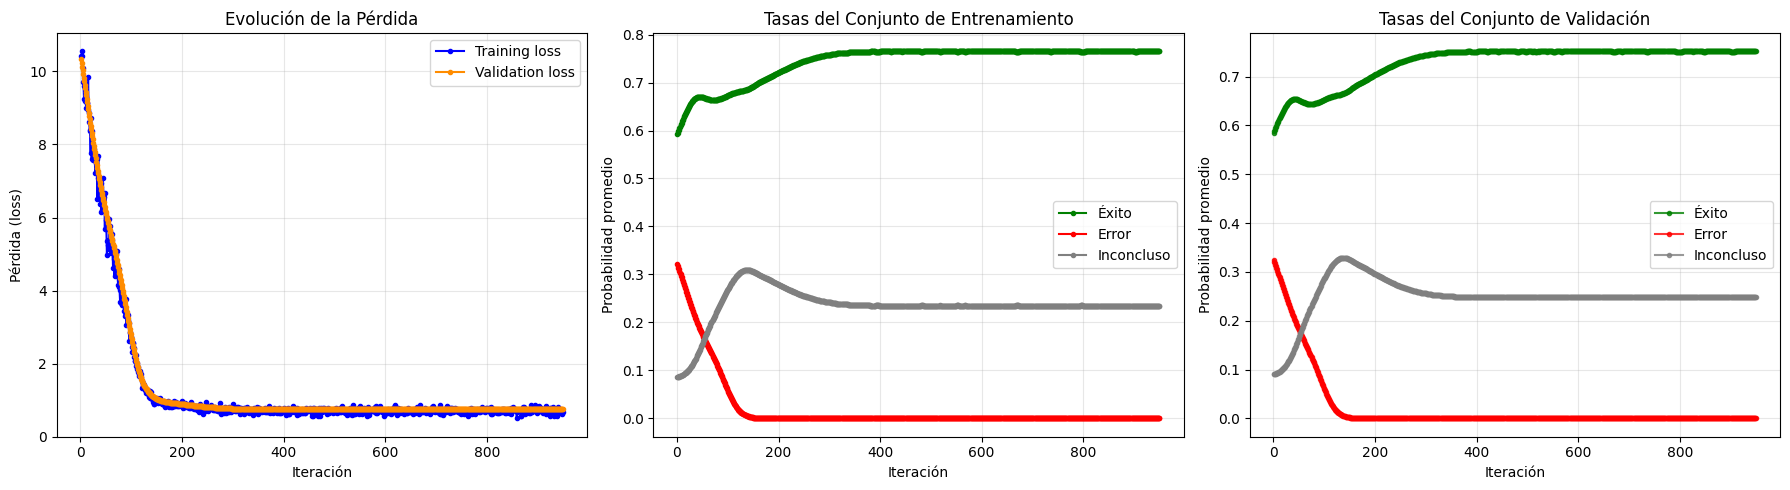

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

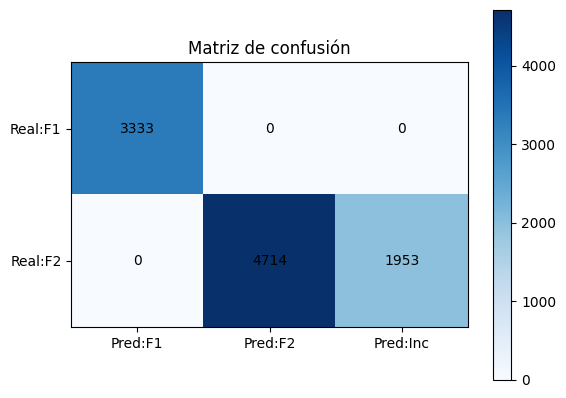

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
